## Setup

### Importing Dependencies

In [1]:
# Data Loading
from datasets import load_dataset
import pandas as pd

# Torch for training models
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel # For obtaining GPT-2 embeddings

# Mathematical libraries
import numpy as np
import math
import cmath
import random
from scipy import stats
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils import check_array
from sklearn.cluster import MiniBatchKMeans
import dcor

# Visualization and data saving
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import umap
import pickle

# Utitlties
import copy
from collections import Counter
from functools import partial

### Fixing Random Seeds for Reproducibility

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Making QLens Folder to Store Results

In [3]:
proj_dir = "QLens/" # Personalize if needed
os.makedirs(proj_dir, exist_ok=True)

## Dataset Preprocessing

### Compiling User Data

In [5]:
# Loading the Amazon Books Dataset files

# Item file
item_file = "Books.item"

# Interations file
inter_file = "Books.inter"

In [6]:
# Reading the interactions file
inter_df = pd.read_csv(f"{proj_dir}{inter_file}", sep='\t')

In [7]:
inter_df.head(3)

,user_id:token,item_id:token,rating:float,timestamp:float
0,A1C6M8LCIX4M6M,0001713353,5.0,1123804800
1,A1REUF3A1YCPHM,0001713353,5.0,1112140800
2,A1YRBRK2XM5D5,0001713353,5.0,1081036800


In [8]:
len(inter_df)

51311621

In [9]:
# Reading the item file
item_df = pd.read_csv(f"{proj_dir}{item_file}", sep='\t')

In [10]:
item_df.head(3)

,item_id:token,title:token,categories:token_seq,brand:token,sales_type:token,sales_rank:float
0,0000092878,Biology Gods Living Creation Third Edition 10 ...,NaN,Keith Graham,Books,1349781.0
1,000047715X,Mksap 16 Audio Companion: Medical Knowledge Se...,'Books',Acp,Books,1702625.0
2,0000004545,"Flex! Discography of North American Punk, Hard...","'Books', 'Music'",Burkhard Jarisch,Books,6291012.0


In [11]:
len(item_df)

3023135

In [12]:
# Filtering item file to only include the needed features and instances
item_df = item_df.loc[:, ['item_id:token', 'title:token']] # Only the item_id and title columns are needed

In [13]:
# Reducing dataset size to the top 50,000 users
TOP_N_USERS = 50000

# Normalizing user id strings (helps avoid subtle dupes)
inter_df['user_id:token'] = inter_df['user_id:token'].astype(str).str.strip()
inter_df['item_id:token'] = inter_df['item_id:token'].astype(str).str.strip()

# Selecting the TOP_N_USERS users with the most interactions
top_users = inter_df['user_id:token'].value_counts().nlargest(TOP_N_USERS).index

# Filtering interactions to those top users only
inter_df = inter_df[inter_df['user_id:token'].isin(top_users)].copy()

# Reseting index for cleanliness
inter_df.reset_index(drop=True, inplace=True)

In [14]:
len(inter_df)

7821134

In [15]:
# Removing items not referenced in interactions file
used_item_ids = set(inter_df['item_id:token'].unique())
item_df = item_df[item_df['item_id:token'].isin(used_item_ids)].copy()

In [16]:
# Keeping only the first occurrence of each item_id:token
item_df_deduped = item_df.drop_duplicates(subset=['item_id:token'], keep='first')

print("After dedupe - item_df rows:", len(item_df_deduped))
print("Unique item_ids:", item_df_deduped['item_id:token'].nunique())

After dedupe - item_df rows: 1073276
Unique item_ids: 1073276


In [17]:
# Keeping only interactions that reference items with titles we have
merged = inter_df.merge(item_df_deduped, on='item_id:token', how='inner', suffixes=(None, '_item'))

In [18]:
len(merged)

7820669

In [19]:
merged.head()

,user_id:token,item_id:token,rating:float,timestamp:float,title:token
0,A3H9YD6K9TVKDP,0001713353,5.0,1383436800,"King, the Mice and the Cheese (Beginner Books)"
1,AHXMDCU0N15TN,0001713353,5.0,1357084800,"King, the Mice and the Cheese (Beginner Books)"
2,ATHTCOG6BB6WK,0001713353,5.0,1313366400,"King, the Mice and the Cheese (Beginner Books)"
3,A2LGACKSC0MALY,0001061240,5.0,1473984000,The golden treasury of poetry
4,A364VBQMMXKX1Q,0001061240,5.0,1437955200,The golden treasury of poetry


In [20]:
# Creating a 5-core inspired version of the dataset

MIN_ITEM_FREQ = 5
MIN_USER_INTER = 5
MAX_USER_INTER = 200

df = merged[['user_id:token', 'item_id:token', 'title:token', 'timestamp:float']].copy()

while True: # Iterating until df becomes stable
    prev_n = len(df)

    # Removing rare items
    item_counts = df['title:token'].value_counts()
    keep_items = item_counts[item_counts >= MIN_ITEM_FREQ].index
    df = df[df['title:token'].isin(keep_items)]

    # Recompute user counts and removing users outside the range [MIN_USER_INTER, MAX_USER_INTER]
    user_counts = df['user_id:token'].value_counts()
    keep_users = user_counts[(user_counts >= MIN_USER_INTER) & (user_counts <= MAX_USER_INTER)].index
    df = df[df['user_id:token'].isin(keep_users)]

    # Stop condition: No change in df over loop
    if len(df) == prev_n:
        break

In [21]:
# Sorting per user by timestamp to build ordered histories
df.sort_values(['user_id:token', 'timestamp:float'], inplace=True)

In [22]:
df.head()

,user_id:token,item_id:token,title:token,timestamp:float
4239078,A0020356UF96ZV361ST,1508785929,Finessers 3,1433376000
4280351,A0020356UF96ZV361ST,1512208086,These Niggas Ain't Loyal (Volume 1),1433721600
5895642,A0020356UF96ZV361ST,1940574366,Promiscuous Girl (G Street Chronicles),1433808000
5295120,A0020356UF96ZV361ST,1938442881,Nikki (G Street Chronicles Presents),1433894400
5336910,A0020356UF96ZV361ST,1940574390,Dope Girl's Ambition (G Street Chronicles Pres...,1434153600


In [23]:
len(df)

3526736

In [4]:
# Saving the 5-core df
df_file = '5_Core_Books_50k.tsv'
df.to_csv(f'{proj_dir}{df_file}', sep = '\t', index = False)

NameError: name 'df' is not defined

#### Reading the 5-core df File

In [5]:
df = pd.read_csv(f'{proj_dir}{df_file}', sep = '\t')

#### Constructing Data Splits

In [6]:
# Obtaining statistics of df
unique_titles = df['title:token'].unique()
num_items = len(unique_titles)
print(f"Filtered dataset has {num_items} unique items and {df['user_id:token'].nunique()} users.")

Filtered dataset has 185136 unique items and 42696 users.


In [7]:
# Mapping book titles to new 0-based ids
title_to_id = pd.Series(np.arange(num_items), index=unique_titles).to_dict()
df['item_new_id'] = df['title:token'].map(title_to_id).astype(np.int64)

In [8]:
# Building per-user histories (list of item ids)
user_hist_series = df.groupby('user_id:token')['item_new_id'].apply(list) # pandas Series

user_histories = user_hist_series.tolist() # List of lists

In [9]:
# Creating data splits
train_set = [hist[:-2] for hist in user_histories]
val_set   = [hist[:-1] for hist in user_histories]
test_set  = [hist for hist in user_histories]

### Initial Embedding Generation

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Loading GPT-2
gpt2_model = GPT2Model.from_pretrained("gpt2").to(device).eval()

# Iteratating over `unique_titles` in batches to compute an embedding vector per title:
BATCH = 64  # tune batch size to fit GPU memory
d_embedding = gpt2_model.config.hidden_size

# Preallocating tensor for embeddings (num_items, d_embedding)
base_embeddings = torch.zeros((num_items, d_embedding), dtype=torch.float32)

for i in tqdm(range(0, num_items, BATCH), desc="Generating title embeddings"):
    batch_titles = list(unique_titles[i:i+BATCH])
    # Tokenize this small batch (padding to max length in the batch)
    enc = tokenizer(batch_titles, return_tensors='pt', padding=True, truncation=False)
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = gpt2_model(**enc)
        last_hidden = outputs.last_hidden_state  # (batch, seq_len, hidden)
        attention_mask = enc['attention_mask']
        last_token_indices = attention_mask.sum(dim=1).long() - 1  # (batch,)

        # Gathering the last token embedding for each sequence in batch
        batch_idx = torch.arange(last_hidden.size(0), device=device)
        batch_embeds = last_hidden[batch_idx, last_token_indices, :].float().cpu()

    # Writing into a preallocated tensor
    start = i
    end = i + batch_embeds.size(0)
    base_embeddings[start:end, :] = batch_embeds

    # free GPU memory
    torch.cuda.empty_cache()

# Appending a PAD embedding row (zeros) to facilitate future batching
pad_embedding = torch.zeros(1, d_embedding)
base_embeddings = torch.cat([base_embeddings, pad_embedding], dim=0)  # shape (num_items+1, d_embedding)

Generating title embeddings: 100%|██████████| 2893/2893 [02:46<00:00, 17.39it/s]


In [30]:
# Saving embeddings to for reuse
torch.save(base_embeddings, os.path.join(proj_dir, 'base_embeddings.pt'))

#### Loading the Base Embeddings

In [10]:
base_embeddings = torch.load(os.path.join(proj_dir, 'base_embeddings.pt'))

### Dataset Class

In [11]:
class BooksDataset(Dataset):
    def __init__(self, user_histories):
        # user_histories is a list of lists of ints (item ids)
        self.user_histories = user_histories

    def __len__(self):
        return len(self.user_histories)

    def __getitem__(self, idx):
        hist = self.user_histories[idx]

        return torch.tensor(hist, dtype=torch.long)

"""
collate_fn() prepares batches for processing by padding them

Args:
    batch (List of 1D LongTensors): Input batch to pad

Returns:
    padded_batch (LongTensor): Padded batch
"""
def collate_fn(batch, pad_token_id):
    padded = pad_sequence(batch, batch_first=True, padding_value=pad_token_id)

    return padded

## Training Base Model

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, init_embeddings_tensor, d_embedding, d_model, dim_feedforward, num_heads, dim_class, dropout_rate=0.1, max_seq_len = 275, pad_token_id=None):
        super().__init__()
        self.pad_token_id = pad_token_id

        # init_embeddings_tensor should be a FloatTensor of shape (num_embeddings, d_embedding)
        assert isinstance(init_embeddings_tensor, torch.Tensor)
        num_embeddings, emb_dim = init_embeddings_tensor.shape
        assert emb_dim == d_embedding

        # Creating the embedding layer initalizede to a copy of the input embeddings
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=d_embedding, padding_idx=self.pad_token_id)
        with torch.no_grad():
            self.embedding.weight.copy_(init_embeddings_tensor)

        # Positional Embedding Layer
        self.max_seq_len = max_seq_len
        self.pos_embedding = nn.Embedding(num_embeddings = max_seq_len, embedding_dim = d_model)
        nn.init.normal_(self.pos_embedding.weight, mean=0.0, std=0.02)

        # Model compression, attention, and MLP layers
        self.compression = nn.Linear(d_embedding, d_model)
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout_rate, batch_first=True)
        self.w1 = nn.Linear(d_model, dim_feedforward)
        self.attention_dropout = nn.Dropout(dropout_rate)
        self.w2 = nn.Linear(dim_feedforward, d_model)
        self.attention_norm = nn.LayerNorm(d_model)
        self.mlp_norm = nn.LayerNorm(d_model)
        self.w1_dropout = nn.Dropout(dropout_rate)
        self.w2_dropout = nn.Dropout(dropout_rate)

        # Classification layer over all valid items
        self.classification_layer = nn.Linear(d_model, dim_class)

        # Training trackers
        self.past_epochs = 0
        self.train_losses = []

    def forward(self, tokens, return_probs=True):

        x = self.embedding(tokens)  # (batch, seq_len, d_embedding)
        compressed = self.compression(x.float())

        # Positional Embeddings
        batch_len, seq_len = tokens.size()
        pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
        pos_embeds = self.pos_embedding(pos_ids)

        compressed = compressed + pos_embeds

        # Attention layer
        causal_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool, device=compressed.device), diagonal=1)
        key_padding_mask = (tokens == self.pad_token_id)
        attn_out = self.attention(compressed, compressed, compressed, attn_mask=causal_mask, key_padding_mask=key_padding_mask)[0]
        attn_out = attn_out.masked_fill(key_padding_mask.unsqueeze(-1), 0.0)

        y = compressed + self.attention_dropout(attn_out)
        y = self.attention_norm(y)

        # MLP Layer
        mlp_out = self.w1_dropout(nn.functional.gelu(self.w1(y)))
        mlp_out = self.w2_dropout(self.w2(mlp_out))
        y = y + mlp_out
        y = self.mlp_norm(y)

        # Final Classifcation layer
        final_logits = self.classification_layer(y)  # (batch, seq_len, dim_class)
        if not return_probs:
            return final_logits
        else:
            return nn.functional.softmax(final_logits, dim=-1)

    def train_model(self, train_dataloader, criterion, optimizer, num_epochs, device, proj_dir, scheduler=None):
        """
        Model training loop.

        Args:
            train_dataloader (DataLoader): DataLoader of training BooksDataset.
            criterion (torch.nn.loss): Loss function used to train model.
            optimizer (torch.optim): Training optimizer.
            num_epochs (int): Number of epochs to train for.
            device (torch.device): Device to train model on.
            proj_dir (str): Name of project directory to save checkpoints to.
            scheduler (torch.optim.lr_scheduler._LRScheduler or OneCycleLR, optional): If provided,
                will be used to adjust learning rate. If OneCycleLR, the learning
                rate will be stepped per-batch; otherwise once per epoch.
        """

        print("Starting training loop...")
        steps_per_epoch = len(train_dataloader) if hasattr(train_dataloader, '__len__') else None

        # Helper to determine whether scheduler expects per-batch stepping
        per_batch_scheduler = isinstance(scheduler, OneCycleLR)

        start_epoch = self.past_epochs
        for epoch in range(start_epoch, start_epoch + num_epochs):
            self.train()
            epoch_loss = 0.0

            # Progress bar for epoch
            for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{start_epoch + num_epochs}")):
                batch = batch.to(device)
                assert batch.dim() == 2

                # Preparing inputs and labels
                pad_mask = (batch != self.pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1)          # (B,)

                input_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                label_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                for i in range(batch.shape[0]):
                    input_tokens[i, :] = torch.cat((batch[i, :lengths[i] - 1], batch[i, lengths[i]:]))
                    label_tokens[i, :] = batch[i, 1:]

                input_tokens = input_tokens.to(torch.long)
                label_tokens = label_tokens.to(torch.long)

                # Zeroing the optimizer
                optimizer.zero_grad()

                # Obtaining logits
                logits = self(input_tokens, return_probs=False)
                b, s, v = logits.shape
                logits_flat = logits.reshape(-1, v)
                labels_flat = label_tokens.reshape(-1)

                # Computing loss
                loss = criterion(logits_flat, labels_flat)
                epoch_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                # Step per-batch scheduler (OneCycleLR MUST be stepped per batch)
                if per_batch_scheduler and (scheduler is not None):
                    scheduler.step()

            average_epoch_loss = epoch_loss / max(1, len(train_dataloader))
            self.train_losses.append(average_epoch_loss)

            # If scheduler is not a per-batch one, stepping it once per epoch
            if scheduler is not None and (not per_batch_scheduler):
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers (e.g., ReduceLROnPlateau) require a metric; skip here
                    pass

            # Obtaining current LR to print
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            # Formating training tracker message
            msg = f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Average Loss: {average_epoch_loss:.4f}, Learning Rate: {current_lr:.6g}"

            # Intermediate evaluation on train set to get NDCG@10 and MRR metrics
            eval_results = self.eval_model(train_dataloader, criterion, device)
            ndcg10 = eval_results.get("NDCG@10", float("nan"))
            mrr = eval_results.get("MRR@10", float("nan"))
            msg += f", NDCG@10: {ndcg10:.4f}, MRR: {mrr:.4f}"

            print(msg)
            print('---\n')

        # Updating number of epochs that the model has been trained for
        self.past_epochs += num_epochs

        # Updating the positional embedding weight for sequence lengths longer than that in training
        with torch.no_grad():
            self.pos_embedding.weight[self.max_seq_len - 2] = self.pos_embedding.weight[self.max_seq_len - 3]
            self.pos_embedding.weight[self.max_seq_len - 1] = self.pos_embedding.weight[self.max_seq_len - 3]

        # Saving Checkpoint (include scheduler state if present)
        checkpoint = {
            'epoch': self.past_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + f'model_checkpoint_{self.past_epochs}_epochs.pth')
        print(f"Checkpoint for Epoch {self.past_epochs} saved")

        # Visualzing loss vs epochs
        plt.figure()
        plt.plot(np.array(range(1, self.past_epochs + 1)), np.array(self.train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch Number")
        plt.savefig(proj_dir + "model_training_loss.png")
        plt.show()


    def eval_model(self, test_dataloader, criterion, device, k = 10):
        """
        Evaluates model using the last item per user on the following criteria:
          - average loss
          - Normalized Discounted Cumulative Gain at k (NDCG@k)
          - Mean Reciprocal Rank at k (MRR@k)

        Args:
            test_dataloader (DataLoader): Contains evaluation set batches.
            criterion (torch.nn.loss): Loss function to compute evaluation loss
            device (torch.device): Device to run evaluation on.
            k (int, optional): k value to compute NDCG@k for, defaults to 10.

        Returns:
            (dict): Contains average evaluation loss, NDCG@k, and MRR@k.
        """

        self.eval()

        val_loss = 0.0
        ndcg_total = 0.0
        rr_total = 0.0
        total_valid = 0  # Number of non-padded last items used in evaluation

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Model Evaluation"):
                batch = batch.to(device)  # (batch, seq_len)

                # Preparing inputs and labels
                pad_mask = (batch != self.pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1)          # (B,)

                input_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                label_tokens = torch.zeros(batch.shape[0]).to(device)
                for i in range(batch.shape[0]):
                    input_tokens[i, :] = torch.cat((batch[i, :lengths[i] - 1], batch[i, lengths[i]:]))
                    label_tokens[i] = batch[i, lengths[i] - 1]

                input_tokens = input_tokens.to(torch.long)
                label_tokens = label_tokens.to(torch.long)

                logits = self(input_tokens, return_probs=False)  # (batch, seq_len-1, vocab_size)

                final_logits = torch.zeros([logits.shape[0], 1, logits.shape[2]]).to(device)
                for i in range(logits.shape[0]):
                    final_logits[i, :, :] = logits[i, lengths[i] - 2, :]

                final_logits = final_logits.squeeze(1)

                # Loss is only calculated on positions not containing the pad token
                try:
                    val_loss += criterion(final_logits, label_tokens).item()
                except Exception as e:
                    # Rare shape mismatch fallback: force shape
                    val_loss += criterion(final_logits, label_tokens.view(-1)).item()

                # Ranking for NDCG & MRR
                # Skipping ranking if pad token is seen in the labels
                valid_mask = (label_tokens != self.pad_token_id)  # shape (batch,)
                if valid_mask.sum().item() == 0:
                    continue

                # Computing top-k indices
                topk_vals, topk_idx = torch.topk(final_logits, k=k, dim=-1)  # (batch, k)

                # Iterating over all valid examples
                labels = label_tokens[valid_mask]
                topk_rows = topk_idx[valid_mask]  # shape (num_valid, k)
                num_valid = labels.size(0)

                for i in range(num_valid):
                    true_item = int(labels[i].item())
                    topk_row = topk_rows[i]

                    # Returns index of match (if present) between logits for i-th user and the true item
                    matches = (topk_row == true_item).nonzero(as_tuple=False)

                    if matches.numel() > 0:
                        rank_index = int(matches[0].item())  # Zero-based indexing is used within top-k
                        dcg = 1.0 / math.log2(rank_index + 2)  # 1-based rank is used in NDCG and MRR
                        rr = 1.0 / (rank_index + 1)
                    else:
                        dcg = 0.0
                        rr = 0.0

                    ndcg_total += dcg
                    rr_total += rr

                total_valid += num_valid

        # Computing averaged evaluation metrics
        avg_val_loss = val_loss / max(1, len(test_dataloader))
        avg_ndcg_at_k = ndcg_total / max(1, total_valid) if total_valid > 0 else 0.0
        avg_mrr_at_k = rr_total / max(1, total_valid) if total_valid > 0 else 0.0

        print(f"\nEvaluation Loss: {avg_val_loss:.4f}, NDCG@{k}: {avg_ndcg_at_k:.4f}, MRR@{k}: {avg_mrr_at_k:.4f}")

        return {
            "avg_val_loss": avg_val_loss,
            f"NDCG@{k}": avg_ndcg_at_k,
            f"MRR@{k}": avg_mrr_at_k
        }

In [17]:
## Preparing for training

# Selecting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_embeddings = torch.load(os.path.join(proj_dir, 'base_embeddings.pt'))  # shape (num_items+1, d_embedding)
init_embeddings = base_embeddings.float()

num_items = base_embeddings.shape[0] - 1  # Excluding pad row for classes
pad_idx = num_items

# Hyperparamters
d_embedding = base_embeddings.shape[1]
d_model = 128
num_heads = 4
d_ff = 512
batch_size = 8
num_epochs = 15
MAX_USER_INTER = 200

# Datasets
train_dataset = BooksDataset(train_set)
val_dataset  = BooksDataset(val_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, pad_token_id=pad_idx))
val_dataloader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=pad_idx))

model = TransformerModel(init_embeddings_tensor=init_embeddings,
                         d_embedding=d_embedding,
                         d_model=d_model,
                         dim_feedforward=d_ff,
                         num_heads=num_heads,
                         dim_class=num_items,  # number of real items
                         dropout_rate=0.1,
                         max_seq_len = MAX_USER_INTER,
                         pad_token_id=pad_idx)
    
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=pad_idx)

### Training for 15 Epochs

Starting training loop...


Model Evaluation: 100%|██████████| 5337/5337 [00:52<00:00, 102.51it/s]



Evaluation Loss: 10.4932, NDCG@10: 0.0089, MRR@10: 0.0072
Epoch [1/15], Average Loss: 11.0920, Learning Rate: 0.000989085, NDCG@10: 0.0089, MRR: 0.0072
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.47it/s]



Evaluation Loss: 9.7866, NDCG@10: 0.0201, MRR@10: 0.0167
Epoch [2/15], Average Loss: 10.0604, Learning Rate: 0.000956816, NDCG@10: 0.0201, MRR: 0.0167
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.43it/s]



Evaluation Loss: 9.0676, NDCG@10: 0.0370, MRR@10: 0.0307
Epoch [3/15], Average Loss: 9.4815, Learning Rate: 0.000904604, NDCG@10: 0.0370, MRR: 0.0307
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.24it/s]



Evaluation Loss: 8.4676, NDCG@10: 0.0597, MRR@10: 0.0496
Epoch [4/15], Average Loss: 9.0402, Learning Rate: 0.000834731, NDCG@10: 0.0597, MRR: 0.0496
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.64it/s]



Evaluation Loss: 7.9352, NDCG@10: 0.0866, MRR@10: 0.0726
Epoch [5/15], Average Loss: 8.6371, Learning Rate: 0.00075025, NDCG@10: 0.0866, MRR: 0.0726
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.48it/s]



Evaluation Loss: 7.4165, NDCG@10: 0.1228, MRR@10: 0.1038
Epoch [6/15], Average Loss: 8.2817, Learning Rate: 0.000654854, NDCG@10: 0.1228, MRR: 0.1038
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.20it/s]



Evaluation Loss: 6.9609, NDCG@10: 0.1584, MRR@10: 0.1349
Epoch [7/15], Average Loss: 7.9512, Learning Rate: 0.000552712, NDCG@10: 0.1584, MRR: 0.1349
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.98it/s]



Evaluation Loss: 6.4749, NDCG@10: 0.2077, MRR@10: 0.1785
Epoch [8/15], Average Loss: 7.5708, Learning Rate: 0.000448288, NDCG@10: 0.2077, MRR: 0.1785
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.70it/s]



Evaluation Loss: 5.9689, NDCG@10: 0.2554, MRR@10: 0.2217
Epoch [9/15], Average Loss: 7.2095, Learning Rate: 0.000346146, NDCG@10: 0.2554, MRR: 0.2217
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.26it/s]



Evaluation Loss: 5.6549, NDCG@10: 0.2905, MRR@10: 0.2543
Epoch [10/15], Average Loss: 6.8692, Learning Rate: 0.00025075, NDCG@10: 0.2905, MRR: 0.2543
---



Model Evaluation: 100%|██████████| 5337/5337 [00:51<00:00, 104.61it/s]



Evaluation Loss: 5.3268, NDCG@10: 0.3253, MRR@10: 0.2874
Epoch [11/15], Average Loss: 6.5677, Learning Rate: 0.000166269, NDCG@10: 0.3253, MRR: 0.2874
---



Model Evaluation: 100%|██████████| 5337/5337 [00:51<00:00, 104.52it/s]



Evaluation Loss: 5.0942, NDCG@10: 0.3516, MRR@10: 0.3130
Epoch [12/15], Average Loss: 6.2896, Learning Rate: 9.6396e-05, NDCG@10: 0.3516, MRR: 0.3130
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.79it/s]



Evaluation Loss: 4.9492, NDCG@10: 0.3684, MRR@10: 0.3295
Epoch [13/15], Average Loss: 6.0577, Learning Rate: 4.4184e-05, NDCG@10: 0.3684, MRR: 0.3295
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.79it/s]



Evaluation Loss: 4.8643, NDCG@10: 0.3787, MRR@10: 0.3393
Epoch [14/15], Average Loss: 5.8879, Learning Rate: 1.19153e-05, NDCG@10: 0.3787, MRR: 0.3393
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.15it/s]



Evaluation Loss: 4.8460, NDCG@10: 0.3810, MRR@10: 0.3416
Epoch [15/15], Average Loss: 5.7838, Learning Rate: 1e-06, NDCG@10: 0.3810, MRR: 0.3416
---

Checkpoint for Epoch 15 saved


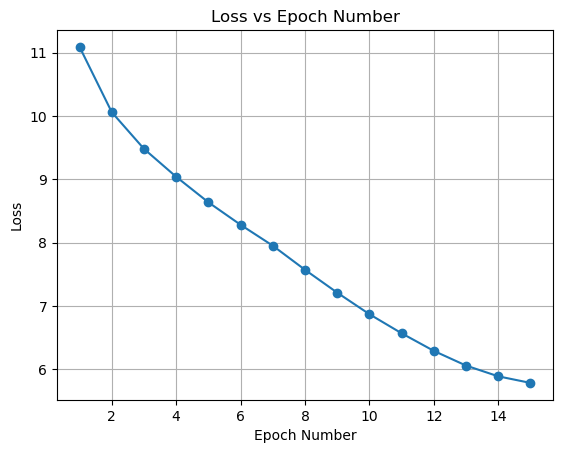

In [19]:
# Clearing memory before training
torch.cuda.empty_cache()

# Cosine based learning rate scheduler
base_lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

model.train_model(train_loader, criterion, optimizer, num_epochs, device, proj_dir, scheduler=scheduler)

### Conducting Model Evaluation on Validation Set

In [20]:
# Model evaluation
val_dataset  = BooksDataset(val_set)
val_dataloader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=pad_idx))

model.eval_model(test_dataloader = val_dataloader,
                  criterion = criterion,
                  device = device)

Model Evaluation: 100%|██████████| 5337/5337 [00:49<00:00, 106.81it/s]


Evaluation Loss: 12.0165, NDCG@10: 0.0598, MRR@10: 0.0530


{'avg_val_loss': 12.0164623391836,
 'NDCG@10': 0.05979255404173229,
 'MRR@10': 0.0530293254488729}

### Training for 20 Epochs

Starting training loop...


Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.98it/s]



Evaluation Loss: 4.8428, NDCG@10: 0.3811, MRR@10: 0.3417
Epoch [16/20], Average Loss: 5.7500, Learning Rate: 1e-06, NDCG@10: 0.3811, MRR: 0.3417
---



Model Evaluation: 100%|██████████| 5337/5337 [00:51<00:00, 104.61it/s]



Evaluation Loss: 4.8405, NDCG@10: 0.3814, MRR@10: 0.3419
Epoch [17/20], Average Loss: 5.7473, Learning Rate: 1e-06, NDCG@10: 0.3814, MRR: 0.3419
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.91it/s]



Evaluation Loss: 4.8392, NDCG@10: 0.3815, MRR@10: 0.3422
Epoch [18/20], Average Loss: 5.7479, Learning Rate: 1e-06, NDCG@10: 0.3815, MRR: 0.3422
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.85it/s]



Evaluation Loss: 4.8375, NDCG@10: 0.3819, MRR@10: 0.3425
Epoch [19/20], Average Loss: 5.7460, Learning Rate: 1e-06, NDCG@10: 0.3819, MRR: 0.3425
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.07it/s]



Evaluation Loss: 4.8362, NDCG@10: 0.3819, MRR@10: 0.3425
Epoch [20/20], Average Loss: 5.7446, Learning Rate: 1e-06, NDCG@10: 0.3819, MRR: 0.3425
---

Checkpoint for Epoch 20 saved


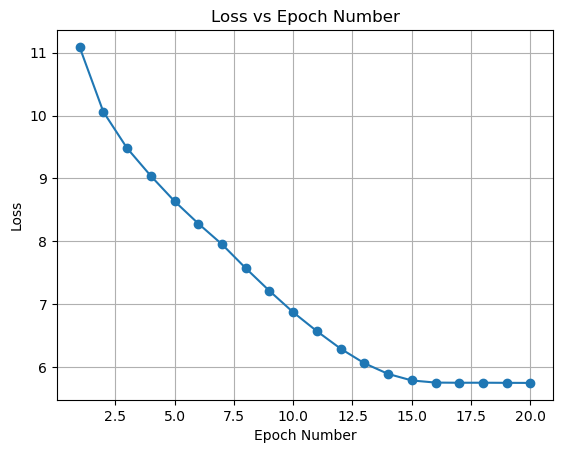

In [21]:
# Model training
num_epochs = 5
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

model.train_model(train_loader, criterion, optimizer, num_epochs, device, proj_dir, scheduler=scheduler)

### Conducting Model Evaluation on Validation Set

In [22]:
model.eval_model(test_dataloader = val_dataloader,
                  criterion = criterion,
                  device = device)

Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 106.18it/s]


Evaluation Loss: 12.0273, NDCG@10: 0.0599, MRR@10: 0.0531


{'avg_val_loss': 12.02732190492561,
 'NDCG@10': 0.05985065495702169,
 'MRR@10': 0.053104682866838525}

### Test Set Evaluation

In [23]:
test_dataset  = BooksDataset(test_set)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=pad_idx))

model.eval_model(test_dataloader = test_dataloader,
                  criterion = criterion,
                  device = device)

Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 106.68it/s]


Evaluation Loss: 13.0786, NDCG@10: 0.0473, MRR@10: 0.0422


{'avg_val_loss': 13.078569845021251,
 'NDCG@10': 0.04733145436562302,
 'MRR@10': 0.04216412042613546}

## Preparing Tuned Lenses

### Defining Classes and Loss Function

In [ ]:
class EmbeddingModel(nn.Module):
# A component of the original Transformer consisting of only its embedding and compression layers
  def __init__(self, embedding, pos_embedding, compression):
    super(EmbeddingModel, self).__init__()

    # Initializing Layers
    self.embedding = embedding
    self.compression = compression

    # Positional Embedding Layer
    self.pos_embedding = pos_embedding

    # Freezing embedding_model parameters
    for param in self.parameters():
      param.requires_grad = False


  def forward(self, tokens):
    """
    Forward pass through embedding model

    Args:
        tokens (torch.Tensor): Contains input title IDs

    Returns:
        final_embeds (torch.Tensor): Contains final compressed embeddigs
    """

    # Embedding layer
    embeds = self.embedding(tokens)

    # Compression layer
    compressed_embeddings = self.compression(embeds.float())

    # Positional Embeddings
    batch_len, seq_len = tokens.size()
    pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
    pos_embeds = self.pos_embedding(pos_ids)

    # Combining Embeddings
    final_embeds = compressed_embeddings + pos_embeds

    return final_embeds

class AttentionModel(nn.Module):
# A component of the original Transformer consisting of only its embedding, compression, and attention layers
  def __init__(self, embedding, pos_embedding, compression, attention, pad_token_id = None):
    super(AttentionModel, self).__init__()

    # Initializing Layers
    self.embedding = embedding
    self.compression = compression
    self.pos_embedding = pos_embedding
    self.attention = attention

    # Setting pad token
    self.pad_token_id = pad_token_id

    # Freezing model parameters
    for param in self.parameters():
      param.requires_grad = False


  def forward(self, tokens):
    """
    Forward pass through attention model

    Args:
        tokens (torch.Tensor): Contains input title IDs

    Returns:
        res_stream (torch.Tensor): Residual stream state after the attention layer
    """

    # Embedding
    embeds = self.embedding(tokens)

    # Compression
    compressed_embeddings = self.compression(embeds)

    # Positional Embeddings
    batch_len, seq_len = tokens.size()
    pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
    pos_embeds = self.pos_embedding(pos_ids)

    # Combining Embeddings
    final_embeds = compressed_embeddings + pos_embeds

    # Attention
    seq_len = final_embeds.size(1)
    causal_mask = torch.triu(
                                torch.ones(seq_len, seq_len, device=final_embeds.device, dtype=torch.bool),
                                diagonal=1
                            )
    key_padding_mask = (tokens == self.pad_token_id)
    attention_output = self.attention(final_embeds, final_embeds, final_embeds, attn_mask = causal_mask, key_padding_mask = key_padding_mask)[0]

    # Residual Addition
    res_stream = final_embeds + attention_output

    return res_stream

In [ ]:
class TunedLens(nn.Module):
    def __init__(self, d_model, last_norm, unembedding_layer, name, bias_only = True):
        super(TunedLens, self).__init__()
        self.bias = nn.Parameter(torch.zeros(d_model))  # shape (d_model,)
        self.layer_norm = last_norm
        self.unembedding = unembedding_layer
        self.name = name

        self.bias_only = bias_only
        # If not a bias only, a learnable weight matrix is also needed
        if not bias_only:
            self.weight_mat = nn.Parameter(torch.zeros(d_model, d_model))

        # freezing layer_norm and unembedding
        for param in self.layer_norm.parameters():
            param.requires_grad = False
        for param in self.unembedding.parameters():
            param.requires_grad = False

    def forward(self, x):
        """
        x: (B, S, d_model)
        adds bias and returns logits: (B, S, V)
        broadcasting of bias over batch and seq dims works via PyTorch broadcasting
        """

        if self.bias_only:
            z = x + self.bias  # broadcasts over last dim
        else:
            z = (x @ self.weight_mat) + self.bias

        z = self.layer_norm(z)
        logits = self.unembedding(z)  # (B, S, vocab_size)

        return logits

    def train_model(self,
                    train_dataloader,
                    criterion,
                    optimizer,
                    num_epochs,
                    device,
                    proj_dir,
                    sub_model,
                    final_model,
                    pad_token_id,
                    scheduler=None):
        """
        Trains the TunedLens.

        - train_dataloader yields batches of token ids -> shape (B, S)
        - sub_model and final_model are passed in and used in eval mode under no_grad()
        - scheduler may be per-batch (e.g., OneCycleLR) or per-epoch; this function
          automatically handles both. It prints the LR after each epoch.
        """
        self.to(device)
        train_losses = []

        # detect per-batch scheduler (OneCycleLR or _get_lr_called_within_step)
        per_batch_scheduler = scheduler is not None and hasattr(scheduler, "step") and getattr(scheduler, "_step_count", None) is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR)

        # ensure teacher models are on device and in eval
        sub_model.to(device)
        final_model.to(device)
        sub_model.eval()
        final_model.eval()

        print("Starting TunedLens training loop...")

        for epoch in range(1, num_epochs + 1):
            self.train()
            epoch_loss = 0.0
            n_batches = 0

            for batch_tokens in tqdm(train_dataloader, desc=f"Epoch {epoch}/{num_epochs}"):
                # batch_tokens: LongTensor (B, S) on CPU or pinned memory; move to device
                batch_tokens = batch_tokens.to(device)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    input_tokens[i, :] = torch.cat((batch_tokens[i, :lengths[i] - 1], batch_tokens[i, lengths[i]:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment

                # compute mask of non-pad tokens (True = valid)
                loss_pad_mask = (input_tokens != pad_token_id)  # (B, S)

                # compute teacher signals in no_grad
                with torch.no_grad():
                    residual = sub_model(input_tokens) # shape: (B, S, d_model)
                    final_logits = final_model(input_tokens, return_probs=False) # shape: (B, S, vocab)

                # forward lens (student)
                student_logits = self(residual)  # (B, S, vocab)

                # compute masked KL loss
                loss = criterion(final_logits.float(), student_logits, pad_mask=loss_pad_mask)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # if scheduler is per-batch (e.g., OneCycleLR) step every batch
                if scheduler is not None and per_batch_scheduler:
                    scheduler.step()

                epoch_loss += loss.item()
                n_batches += 1

            avg_epoch_loss = epoch_loss / max(1, n_batches)
            train_losses.append(avg_epoch_loss)

            # step epoch-based schedulers here
            if scheduler is not None and not per_batch_scheduler:
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers require a metric; we do not call those automatically
                    pass

            # print learning rate
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            print(f"Epoch [{epoch}/{num_epochs}]  Avg Loss: {avg_epoch_loss:.6f}  LR: {current_lr:.6g}")

            # optional: small quick eval on train subset or val set can be triggered here

        # Save checkpoint
        checkpoint = {
            'epoch': num_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + self.name + '_lens_checkpoint.pth')
        print(f"Checkpoint for Epoch {num_epochs} saved to {proj_dir + self.name + '_lens_checkpoint.pth'}")

        # Plot loss curve
        plt.figure()
        plt.plot(np.arange(1, num_epochs + 1), np.array(train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title(f"{self.name} Lens Loss")
        plt.savefig(proj_dir + self.name + "_lens_training_loss.png")
        plt.show()

        return train_losses

    def evaluate_model(self, test_dataloader, criterion, device, sub_model=None, final_model=None, pad_token_id=None):
        """
        Evaluate the TunedLens on batched test data.

        Returns avg loss and accuracy (agreement with teacher's top prediction).
        """
        self.to(device)
        self.eval()
        if sub_model is not None:
            sub_model.to(device)
            sub_model.eval()
        if final_model is not None:
            final_model.to(device)
            final_model.eval()

        total_loss = 0.0
        total_valid = 0
        total_matches = 0

        with torch.no_grad():
            for batch_tokens in tqdm(test_dataloader, desc=f"Eval {self.name} lens"):
                batch_tokens = batch_tokens.to(device)  # (B, S)

                # Preparing inputs and labels
                pad_mask = (batch_tokens != pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

                # All but last token of each sequence is inputted into models
                input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
                for i in range(batch_tokens.shape[0]):
                    input_tokens[i, :] = torch.cat((batch_tokens[i, :lengths[i] - 1], batch_tokens[i, lengths[i]:]))

                input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment

                loss_pad_mask = (input_tokens != pad_token_id)

                residual = sub_model(input_tokens) # (B, S, d_model)
                teacher_logits = final_model(input_tokens, return_probs=False) # (B, S, V)
                student_logits = self(residual) # (B, S, V)

                # compute loss
                batch_loss = criterion(teacher_logits.float(), student_logits, pad_mask=loss_pad_mask)
                total_loss += batch_loss.item() * batch_tokens.size(0)  # weight by batch-size for averaging

                # Teacher logits for last valid position
                teacher_last = torch.zeros([teacher_logits.shape[0], 1, teacher_logits.shape[2]]).to(device)
                for i in range(teacher_logits.shape[0]):
                    teacher_last[i, :, :] = teacher_logits[i, lengths[i] - 2, :]
                teacher_last = teacher_last.squeeze(1)

                # Student logits for last valid position
                student_last = torch.zeros([student_logits.shape[0], 1, student_logits.shape[2]]).to(device)
                for i in range(student_logits.shape[0]):
                    student_last[i, :, :] = student_logits[i, lengths[i] - 2, :]
                student_last = student_last.squeeze(1)

                # Computing accuracy of top-1 on last position against teacher's top-1
                teacher_last_tok = teacher_last.argmax(dim=-1) # (B,)
                student_last_tok = student_last.argmax(dim=-1) # (B,)

                total_matches += (teacher_last_tok == student_last_tok).sum().item()
                total_valid += batch_tokens.size(0)

        avg_loss = total_loss / max(1, total_valid)
        accuracy = total_matches / max(1, total_valid)

        print(f"\nEval {self.name} Lens - Avg loss: {avg_loss:.6f}, Accuracy vs teacher (last pos): {accuracy:.4f}")
        return {"avg_val_loss": avg_loss, "accuracy": accuracy}

In [ ]:
"""
kl_loss() computes the Kullback-Leibler (KL) divergence loss between
two sets of logits in accordance with the original Tuned Lens paper.

Args:
    base_logits (torch.Tensor): The logits from the base Transformer.
    lens_logits (torch.Tensor): The logits from the Tuned Lens model.

Returns:
    torch.Tensor: The mean KL divergence loss over the batch.
"""
def kl_loss_teacher_student(teacher_logits, student_logits, pad_mask=None):
    """
    Mask-aware KL divergence averaged over valid tokens.
    teacher_logits, student_logits: (B, S, V)
    pad_mask: (B, S) boolean where True = valid token; if None, all tokens valid.
    Returns scalar: mean KL over valid tokens.
    """
    # compute log-probabilities
    log_p = nn.functional.log_softmax(teacher_logits, dim=-1)   # log P (teacher)
    log_q = nn.functional.log_softmax(student_logits, dim=-1)   # log Q (student)
    p = torch.exp(log_p)  # P

    # per-token KL: sum over vocab dimension -> shape (B, S)
    per_token_kl = torch.sum(p * (log_p - log_q), dim=-1)

    if pad_mask is None:
        return per_token_kl.mean()
    else:
        # mask: True where valid
        mask = pad_mask.to(per_token_kl.device).float()
        total_valid = mask.sum()
        if total_valid.item() == 0:
            # no valid tokens: avoid divide-by-zero
            return torch.tensor(0.0, device=per_token_kl.device, requires_grad=True)
        masked_sum = (per_token_kl * mask).sum()
        return masked_sum / total_valid


### Preparing Embedding Lens

In [ ]:
# Hyperparameters
batch_size = 16
num_epochs = 25

# Embedding model
embedding_model = EmbeddingModel(model.embedding, model.pos_embedding, model.compression).to(device)

# Dataset + DataLoader that returns batches of token ids
embedding_train_ds = BooksDataset(val_set)
embedding_test_ds  = BooksDataset(test_set)

embedding_train_loader = DataLoader(embedding_train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                          num_workers=2, pin_memory=True)

embedding_test_loader = DataLoader(embedding_test_ds, batch_size=batch_size, shuffle=False,
                         collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                         num_workers=2, pin_memory=True)

# instantiate embedding lens
embedding_lens = TunedLens(d_model=d_model,
                           last_norm=model.mlp_norm,
                           unembedding_layer=model.classification_layer,
                           name='embedding',
                           bias_only = False).to(device)

# optimizer & scheduler
embedding_optimizer = optim.Adam(embedding_lens.parameters(), lr=1e-3)

# OneCycleLR (per-batch based LR)
embedding_scheduler = OneCycleLR(optimizer,
                       max_lr=1e-2,
                       steps_per_epoch=len(embedding_train_loader),
                       epochs=num_epochs,
                       pct_start=0.3)

Starting TunedLens training loop...


Epoch 1/25: 100%|██████████| 12/12 [00:00<00:00, 25.09it/s]


Epoch [1/25]  Avg Loss: 0.227906  LR: 0.000824219


Epoch 2/25: 100%|██████████| 12/12 [00:00<00:00, 23.92it/s]


Epoch [2/25]  Avg Loss: 0.180425  LR: 0.00202189


Epoch 3/25: 100%|██████████| 12/12 [00:00<00:00, 25.54it/s]


Epoch [3/25]  Avg Loss: 0.154702  LR: 0.00378132


Epoch 4/25: 100%|██████████| 12/12 [00:00<00:00, 25.96it/s]


Epoch [4/25]  Avg Loss: 0.132231  LR: 0.00579151


Epoch 5/25: 100%|██████████| 12/12 [00:00<00:00, 27.09it/s]


Epoch [5/25]  Avg Loss: 0.114364  LR: 0.00769715


Epoch 6/25: 100%|██████████| 12/12 [00:00<00:00, 23.71it/s]


Epoch [6/25]  Avg Loss: 0.100817  LR: 0.0091614


Epoch 7/25: 100%|██████████| 12/12 [00:00<00:00, 26.71it/s]


Epoch [7/25]  Avg Loss: 0.088913  LR: 0.00992543


Epoch 8/25: 100%|██████████| 12/12 [00:00<00:00, 25.82it/s]


Epoch [8/25]  Avg Loss: 0.079826  LR: 0.00997261


Epoch 9/25: 100%|██████████| 12/12 [00:00<00:00, 28.25it/s]


Epoch [9/25]  Avg Loss: 0.071619  LR: 0.00979938


Epoch 10/25: 100%|██████████| 12/12 [00:00<00:00, 26.93it/s]


Epoch [10/25]  Avg Loss: 0.063836  LR: 0.00947189


Epoch 11/25: 100%|██████████| 12/12 [00:00<00:00, 20.63it/s]


Epoch [11/25]  Avg Loss: 0.056748  LR: 0.00900067


Epoch 12/25: 100%|██████████| 12/12 [00:00<00:00, 16.84it/s]


Epoch [12/25]  Avg Loss: 0.050199  LR: 0.00840087


Epoch 13/25: 100%|██████████| 12/12 [00:00<00:00, 18.88it/s]


Epoch [13/25]  Avg Loss: 0.044734  LR: 0.00769176


Epoch 14/25: 100%|██████████| 12/12 [00:00<00:00, 18.25it/s]


Epoch [14/25]  Avg Loss: 0.038931  LR: 0.00689614


Epoch 15/25: 100%|██████████| 12/12 [00:00<00:00, 17.60it/s]


Epoch [15/25]  Avg Loss: 0.034289  LR: 0.00603957


Epoch 16/25: 100%|██████████| 12/12 [00:00<00:00, 27.68it/s]


Epoch [16/25]  Avg Loss: 0.030183  LR: 0.0051496


Epoch 17/25: 100%|██████████| 12/12 [00:00<00:00, 24.61it/s]


Epoch [17/25]  Avg Loss: 0.027973  LR: 0.00425481


Epoch 18/25: 100%|██████████| 12/12 [00:00<00:00, 25.99it/s]


Epoch [18/25]  Avg Loss: 0.025150  LR: 0.00338398


Epoch 19/25: 100%|██████████| 12/12 [00:00<00:00, 33.17it/s]


Epoch [19/25]  Avg Loss: 0.024407  LR: 0.00256509


Epoch 20/25: 100%|██████████| 12/12 [00:00<00:00, 38.12it/s]


Epoch [20/25]  Avg Loss: 0.024051  LR: 0.00182445


Epoch 21/25: 100%|██████████| 12/12 [00:00<00:00, 36.97it/s]


Epoch [21/25]  Avg Loss: 0.023293  LR: 0.00118589


Epoch 22/25: 100%|██████████| 12/12 [00:00<00:00, 37.78it/s]


Epoch [22/25]  Avg Loss: 0.023537  LR: 0.00066991


Epoch 23/25: 100%|██████████| 12/12 [00:00<00:00, 37.03it/s]


Epoch [23/25]  Avg Loss: 0.021835  LR: 0.000293106


Epoch 24/25: 100%|██████████| 12/12 [00:00<00:00, 37.84it/s]


Epoch [24/25]  Avg Loss: 0.022040  LR: 6.75868e-05


Epoch 25/25: 100%|██████████| 12/12 [00:00<00:00, 37.31it/s]


Epoch [25/25]  Avg Loss: 0.021654  LR: 5.99489e-07
Checkpoint for Epoch 25 saved to QLens/embedding_lens_checkpoint.pth


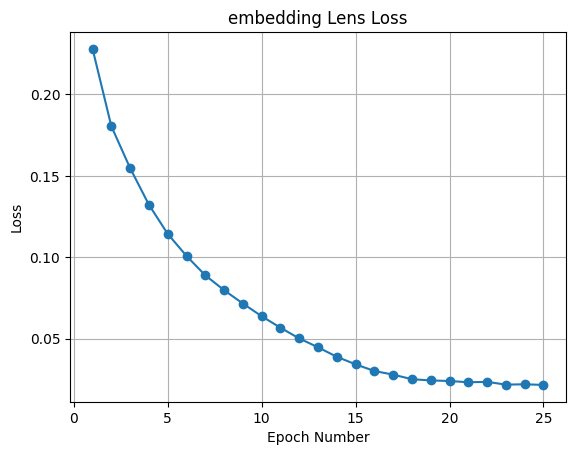

[0.227906105419,
 0.18042542040348053,
 0.15470246970653534,
 0.13223138762017092,
 0.11436410496632259,
 0.10081691667437553,
 0.08891287446022034,
 0.07982600977023442,
 0.07161941130956014,
 0.06383615483840306,
 0.05674829799681902,
 0.05019858727852503,
 0.044734248891472816,
 0.03893107082694769,
 0.03428864742939671,
 0.030182864051312208,
 0.027972595610966284,
 0.025149669032543898,
 0.024406532756984234,
 0.024051093651602667,
 0.023293096882601578,
 0.023537297112246353,
 0.021835388150066137,
 0.022040341670314472,
 0.0216535070600609]

In [ ]:
# Training
embedding_lens.train_model(train_dataloader=embedding_train_loader,
                           criterion=kl_loss_teacher_student,
                           optimizer=embedding_optimizer,
                           num_epochs=num_epochs,
                           device=device,
                           proj_dir=proj_dir,
                           sub_model=embedding_model,     # should return (B,S,d_model)
                           final_model=model,             # teacher model: returns (B,S,V)
                           pad_token_id=pad_idx,
                           scheduler=embedding_scheduler)

In [ ]:
# Evaluation
embedding_lens.evaluate_model(test_dataloader=embedding_test_loader,
                              criterion=kl_loss_teacher_student,
                              device=device,
                              sub_model=embedding_model,
                              final_model=model,
                              pad_token_id=pad_idx)

Eval embedding lens: 100%|██████████| 12/12 [00:00<00:00, 34.53it/s]


Eval embedding Lens - Avg loss: 0.021188, Accuracy vs teacher (last pos): 0.6073


{'avg_val_loss': 0.021188218760942915, 'accuracy': 0.6073298429319371}

### Preparing Attention Lens

In [ ]:
# Hyperparameters
batch_size = 16
num_epochs = 25

# Attention model
attention_model = AttentionModel(model.embedding, model.pos_embedding, model.compression, model.attention, pad_idx).to(device)

# Dataset + DataLoader that returns batches of token ids
attention_train_ds = BooksDataset(val_set)
attention_test_ds  = BooksDataset(test_set)

attention_train_loader = DataLoader(attention_train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                          num_workers=2, pin_memory=True)

attention_test_loader = DataLoader(attention_test_ds, batch_size=batch_size, shuffle=False,
                         collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                         num_workers=2, pin_memory=True)

# instantiate embedding lens
attention_lens = TunedLens(d_model=d_model,
                           last_norm=model.mlp_norm,
                           unembedding_layer=model.classification_layer,
                           name='attention',
                           bias_only = False).to(device)

# optimizer & scheduler
attention_optimizer = optim.Adam(attention_lens.parameters(), lr=1e-3)

# OneCycleLR (per-batch)
attention_scheduler = OneCycleLR(optimizer,
                       max_lr=1e-2,
                       steps_per_epoch=len(attention_train_loader),
                       epochs=num_epochs,
                       pct_start=0.3)

Starting TunedLens training loop...


Epoch 1/25: 100%|██████████| 12/12 [00:00<00:00, 17.25it/s]


Epoch [1/25]  Avg Loss: 0.220265  LR: 0.000824219


Epoch 2/25: 100%|██████████| 12/12 [00:00<00:00, 14.92it/s]


Epoch [2/25]  Avg Loss: 0.169691  LR: 0.00202189


Epoch 3/25: 100%|██████████| 12/12 [00:00<00:00, 18.00it/s]


Epoch [3/25]  Avg Loss: 0.140530  LR: 0.00378132


Epoch 4/25: 100%|██████████| 12/12 [00:00<00:00, 14.50it/s]


Epoch [4/25]  Avg Loss: 0.118266  LR: 0.00579151


Epoch 5/25: 100%|██████████| 12/12 [00:00<00:00, 23.43it/s]


Epoch [5/25]  Avg Loss: 0.101091  LR: 0.00769715


Epoch 6/25: 100%|██████████| 12/12 [00:00<00:00, 25.06it/s]


Epoch [6/25]  Avg Loss: 0.087324  LR: 0.0091614


Epoch 7/25: 100%|██████████| 12/12 [00:00<00:00, 16.81it/s]


Epoch [7/25]  Avg Loss: 0.075839  LR: 0.00992543


Epoch 8/25: 100%|██████████| 12/12 [00:00<00:00, 15.00it/s]


Epoch [8/25]  Avg Loss: 0.065999  LR: 0.00997261


Epoch 9/25: 100%|██████████| 12/12 [00:00<00:00, 13.59it/s]


Epoch [9/25]  Avg Loss: 0.056790  LR: 0.00979938


Epoch 10/25: 100%|██████████| 12/12 [00:00<00:00, 24.60it/s]


Epoch [10/25]  Avg Loss: 0.048248  LR: 0.00947189


Epoch 11/25: 100%|██████████| 12/12 [00:00<00:00, 24.70it/s]


Epoch [11/25]  Avg Loss: 0.039727  LR: 0.00900067


Epoch 12/25: 100%|██████████| 12/12 [00:00<00:00, 26.54it/s]


Epoch [12/25]  Avg Loss: 0.031610  LR: 0.00840087


Epoch 13/25: 100%|██████████| 12/12 [00:00<00:00, 27.46it/s]


Epoch [13/25]  Avg Loss: 0.023814  LR: 0.00769176


Epoch 14/25: 100%|██████████| 12/12 [00:00<00:00, 25.37it/s]


Epoch [14/25]  Avg Loss: 0.016701  LR: 0.00689614


Epoch 15/25: 100%|██████████| 12/12 [00:00<00:00, 26.80it/s]


Epoch [15/25]  Avg Loss: 0.011119  LR: 0.00603957


Epoch 16/25: 100%|██████████| 12/12 [00:00<00:00, 26.17it/s]


Epoch [16/25]  Avg Loss: 0.007403  LR: 0.0051496


Epoch 17/25: 100%|██████████| 12/12 [00:00<00:00, 25.44it/s]


Epoch [17/25]  Avg Loss: 0.005262  LR: 0.00425481


Epoch 18/25: 100%|██████████| 12/12 [00:00<00:00, 24.67it/s]


Epoch [18/25]  Avg Loss: 0.004290  LR: 0.00338398


Epoch 19/25: 100%|██████████| 12/12 [00:00<00:00, 26.14it/s]


Epoch [19/25]  Avg Loss: 0.003873  LR: 0.00256509


Epoch 20/25: 100%|██████████| 12/12 [00:00<00:00, 25.49it/s]


Epoch [20/25]  Avg Loss: 0.003632  LR: 0.00182445


Epoch 21/25: 100%|██████████| 12/12 [00:00<00:00, 25.86it/s]


Epoch [21/25]  Avg Loss: 0.003524  LR: 0.00118589


Epoch 22/25: 100%|██████████| 12/12 [00:00<00:00, 27.18it/s]


Epoch [22/25]  Avg Loss: 0.003374  LR: 0.00066991


Epoch 23/25: 100%|██████████| 12/12 [00:00<00:00, 32.54it/s]


Epoch [23/25]  Avg Loss: 0.003310  LR: 0.000293106


Epoch 24/25: 100%|██████████| 12/12 [00:00<00:00, 28.69it/s]


Epoch [24/25]  Avg Loss: 0.003311  LR: 6.75868e-05


Epoch 25/25: 100%|██████████| 12/12 [00:00<00:00, 26.70it/s]


Epoch [25/25]  Avg Loss: 0.003280  LR: 5.99489e-07
Checkpoint for Epoch 25 saved to QLens/attention_lens_checkpoint.pth


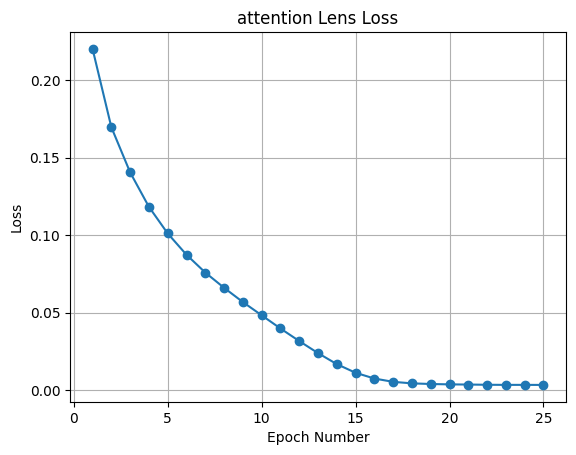

[0.22026471917827925,
 0.1696911690135797,
 0.1405298300087452,
 0.11826553630332153,
 0.10109066280225913,
 0.08732350108524163,
 0.07583874339858691,
 0.06599933747202158,
 0.05679010599851608,
 0.04824821309496959,
 0.03972741402685642,
 0.031609768979251385,
 0.023814376754065354,
 0.01670116069726646,
 0.011118709032113353,
 0.007402874800997476,
 0.005261885196280976,
 0.004289685981348157,
 0.0038727684877812862,
 0.003632235942253222,
 0.0035238832933828235,
 0.003373756907725086,
 0.003309710940811783,
 0.0033107491908594966,
 0.003279634033485005]

In [ ]:
attention_lens.train_model(train_dataloader=attention_train_loader,
                           criterion=kl_loss_teacher_student,
                           optimizer=attention_optimizer,
                           num_epochs=num_epochs,
                           device=device,
                           proj_dir=proj_dir,
                           sub_model=attention_model,
                           final_model=model,
                           pad_token_id=pad_idx,
                           scheduler=attention_scheduler)

In [ ]:
attention_lens.evaluate_model(test_dataloader=attention_test_loader,
                              criterion=kl_loss_teacher_student,
                              device=device,
                              sub_model=attention_model,
                              final_model=model,
                              pad_token_id=pad_idx)

Eval attention lens: 100%|██████████| 12/12 [00:00<00:00, 33.58it/s]


Eval attention Lens - Avg loss: 0.003221, Accuracy vs teacher (last pos): 0.8272


{'avg_val_loss': 0.003220959086244175, 'accuracy': 0.8272251308900523}

## Analyzing Householder Reflection Vectors of Unitary Operators

### Preparing Householder Reflection Vectors

In [ ]:
def get_logits_for_position(batch_tokens, pos, device,
                            embedding_model, attention_model,
                            embedding_lens, attention_lens, model):
    """
    Return logits (B, S, V) for requested position:
      pos == 'embedding'  -> embedding_lens(embedding_model(batch_tokens))
      pos == 'attention'  -> attention_lens(attention_model(batch_tokens))
      pos == 'final'      -> model(batch_tokens, return_probs=False)
    All returned tensors are floats on device (not softmaxed yet).
    """

    if pos == 'embedding':
        # embedding_model -> (B,S,d_model); embedding_lens -> logits (B,S,V)
        residual = embedding_model(batch_tokens)      # ensure embedding_model handles batch on device
        logits = embedding_lens(residual)             # logits (B,S,V)
    elif pos == 'attention':
        residual = attention_model(batch_tokens)
        logits = attention_lens(residual)
    elif pos == 'final':
        # The transformer model's forward with return_probs=False returns logits shape (B,S,V)
        logits = model(batch_tokens, return_probs=False)
    else:
        raise ValueError("pos must be 'embedding', 'attention', or 'final'")

    return logits  # (B,S,V) on same device as model

def compute_last_idx_householder_vectors(
    dataset,
    batch_size=128,
    pos0='embedding',
    pos1='final',
    pad_idx=None,
    device=None,
    embedding_model=None,
    attention_model=None,
    embedding_lens=None,
    attention_lens=None,
    model=None,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
):
    """
    Compute Householder normal vectors for the last valid position in batches.

    Args:
      dataset: BooksDataset (returns 1D LongTensor history)
      batch_size: batch size for DataLoader
      pos0, pos1: 'embedding' | 'attention' | 'final'
      pad_idx: pad token id
      device: torch device (e.g., torch.device('cuda'))
      embedding_model, attention_model, embedding_lens, attention_lens, model: required model objects
      dtype: dtype for intermediate computations (float32 recommended)
    Returns:
      list_of_lists: a Python list length = len(dataset). Each element is a list of numpy arrays (hh vectors for that user's valid positions).
    """

    assert device is not None, "Provide device"
    assert pad_idx is not None, "Provide pad_idx"
    assert model is not None and embedding_model is not None and attention_model is not None, "Provide models"
    # choose which lenses are not None
    assert embedding_lens is not None and attention_lens is not None, "Provide both embedding_lens and attention_lens"

    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        collate_fn=partial(collate_fn, pad_token_id=pad_idx),
                        num_workers=num_workers,
                        pin_memory=pin_memory)

    # make sure the teacher and lenses are in eval and on device
    model.to(device).eval()
    embedding_model.to(device).eval()
    attention_model.to(device).eval()
    embedding_lens.to(device).eval()
    attention_lens.to(device).eval()

    all_hh_vecs = []  # will append per-batch per-sample lists
    all_ket0_vecs = []

    chunk_idx = 0
    saved_chunks = []

    with torch.no_grad():
        for batch_tokens in tqdm(loader, desc="HH batch"):
            # move tokens to device
            batch_tokens = batch_tokens.to(device)

            # Preparing inputs
            pad_mask = (batch_tokens != pad_idx) # (B, S_total)
            lengths = pad_mask.sum(dim=1) # (B,) representing valid sequence lengths

            # All but last token of each sequence is inputted into models
            input_tokens = torch.zeros([batch_tokens.shape[0], batch_tokens.shape[1] - 1]).to(device)
            for i in range(batch_tokens.shape[0]):
                for j in range(batch_tokens.shape[1]):
                    if j < lengths[i] - 1:
                        input_tokens[i, j] = batch_tokens[i, j]
                    elif j > lengths[i] - 1:
                        input_tokens[i, j - 1] = batch_tokens[i, j]

            input_tokens = input_tokens.to(torch.long) # Ensuring d-type alignment

            # compute logits for pos0 and pos1
            logits0 = get_logits_for_position(input_tokens, pos0, device,
                                              embedding_model, attention_model,
                                              embedding_lens, attention_lens, model)
            logits1 = get_logits_for_position(input_tokens, pos1, device,
                                              embedding_model, attention_model,
                                              embedding_lens, attention_lens, model)

            # Initial logits for last valid position in each sequence
            logits0_last = torch.zeros([logits0.shape[0], 1, logits0.shape[2]]).to(device)
            for i in range(logits0.shape[0]):
                logits0_last[i, :, :] = logits0[i, lengths[i] - 2, :]
            logits0_last = logits0_last.squeeze(1)

            # Final logits for last valid position in each sequence
            logits1_last = torch.zeros([logits1.shape[0], 1, logits1.shape[2]]).to(device)
            for i in range(logits1.shape[0]):
                logits1_last[i, :, :] = logits1[i, lengths[i] - 2, :]
            logits1_last = logits1_last.squeeze(1)

            # convert to probabilities in float (stable)
            probs0 = torch.softmax(logits0_last.to(dtype), dim=-1)  # (B, V)
            probs1 = torch.softmax(logits1_last.to(dtype), dim=-1)  # (B, V)

            # State vector construction
            ket0 = torch.sqrt(probs0.clamp(min=1e-30))
            ket1 = torch.sqrt(probs1.clamp(min=1e-30))

            # Householder extraction
            delta = ket1 - ket0
            norms = torch.linalg.norm(delta, dim=1, keepdim=True).clamp(min=1e-12)
            hh_flat = (delta / norms).cpu()  # (B, V)

            # Creating lists of Householder reflection vectors and input state kets
            hh_batch = []
            ket0_batch = []
            for i in range(hh_flat.shape[0]):
                hh_batch.append([hh_flat[i].cpu().numpy()])
                ket0_batch.append([ket0[i].cpu().numpy()])

            # hh_batch and ket0_batch are lists of length B of lists of numpy arrays
            all_hh_vecs.extend(hh_batch)
            all_ket0_vecs.extend(ket0_batch)


    return all_hh_vecs, all_ket0_vecs  # list-of-lists (len = dataset), each inner list contains one numpy array per interaction

In [ ]:
# Dataset
unitary_dataset = BooksDataset(test_set)

# Embedding model
embedding_model = EmbeddingModel(model.embedding, model.pos_embedding, model.compression).to(device)

# Attention model
attention_model = AttentionModel(model.embedding, model.pos_embedding, model.compression, model.attention, pad_idx).to(device)

torch.cuda.empty_cache()

attention_hh_vecs, attention_ket0_vecs = compute_last_idx_householder_vectors(
    unitary_dataset,
    batch_size=16,
    pos0='embedding',
    pos1='attention',
    pad_idx=pad_idx,
    device=device,
    embedding_model=embedding_model,
    attention_model=attention_model,
    embedding_lens=embedding_lens,
    attention_lens=attention_lens,
    model=model,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
HH batch: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


In [ ]:
mlp_hh_vecs, mlp_ket0_vecs = compute_last_idx_householder_vectors(
    unitary_dataset,
    batch_size=16,
    pos0='attention',
    pos1='final',
    pad_idx=pad_idx,
    device=device,
    embedding_model=embedding_model,
    attention_model=attention_model,
    embedding_lens=embedding_lens,
    attention_lens=attention_lens,
    model=model,
    dtype=torch.float32,
    num_workers=4,
    pin_memory=True,
)

HH batch: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]


In [ ]:
# Saving embedding and attention Householder vectors

with open(f'{proj_dir}attention_hh_vecs.pickle', 'wb') as f:
    pickle.dump(attention_hh_vecs, f)

with open(f'{proj_dir}mlp_hh_vecs.pickle', 'wb') as f:
    pickle.dump(mlp_hh_vecs, f)

### PCA-based Analysis

In [ ]:
def efficient_pca(
    vec_source,
    plt_title = 'PCA Plot',
    file_name = 'pca.png',
    create_scatter = True,
    proj_dir="./QLens/",
    n_components=2,
    method="auto",
    batch_size=10000,
    dtype=np.float32,
    plot_max_points=20000,
    random_state=42,
    svd_iter=5,
):
    """
    Perform PCA (efficiently) and scatter-plot first two components.

    Args:
      vec_source: one of:
        - numpy array shape (N, D)
        - list of numpy arrays (list of 2D arrays or list-of-1D arrays)
        - path to .npz/.npz chunk files where each file has 'data' = object array of per-sample vectors
      plt_title, file_name: plot title and filename (saved inside proj_dir)
      method: "auto", "randomized", "incremental", "truncated"
      batch_size: used for IncrementalPCA partial_fit or when reading chunks
      dtype: working dtype (use np.float32)
      plot_max_points: if N > plot_max_points, randomly subsample points for plotting
      svd_iter: n_iter for randomized SVD (if used)
    Returns:
      X_pca (N,2) numpy array of projected points, pca_object (fitted sklearn transformer)
    """

    # -----------------------
    # Helper: get a generator of 2D numpy arrays (batches)
    # -----------------------
    def batch_generator_from_source(src, batch_size):
        # 1) numpy array
        if isinstance(src, np.ndarray):
            N = src.shape[0]
            for i in range(0, N, batch_size):
                yield src[i:i+batch_size].astype(dtype, copy=False)
            return

        # 2) list-like of arrays
        if isinstance(src, (list, tuple)):
            # if list of 1D arrays, stack them in batches
            idx = 0
            while idx < len(src):
                block = src[idx:idx+batch_size]
                # convert each to 2D if needed
                block2 = []
                for v in block:
                    a = np.asarray(v, dtype=dtype)
                    if a.ndim == 1:
                        a = a.reshape(1, -1)
                    block2.append(a)
                yield np.vstack(block2)
                idx += batch_size
            return

        # 3) path or glob of .npz chunk files
        if isinstance(src, str) and os.path.exists(src):
            # detect a single .npz file or directory prefix
            if os.path.isfile(src) and src.endswith(".npz"):
                npz_files = [src]
            elif os.path.isdir(src):
                # get .npz files inside
                npz_files = sorted([os.path.join(src, f) for f in os.listdir(src) if f.endswith(".npz")])
            else:
                raise ValueError("vec_source string must be a .npz file or directory containing .npz files")

            for fn in npz_files:
                data = np.load(fn, allow_pickle=True)["data"]
                # data assumed to be object array of (per-sample) 1D arrays or 2D arrays
                # iterate in batches
                arrs = [np.asarray(x, dtype=dtype).reshape(1, -1) if np.asarray(x).ndim==1 else np.asarray(x, dtype=dtype) for x in data]
                idx = 0
                while idx < len(arrs):
                    block = arrs[idx:idx+batch_size]
                    yield np.vstack(block)
                    idx += batch_size
            return

        raise ValueError("Unsupported vec_source type")

    # -----------------------
    # Decide method automatically if requested
    # -----------------------
    # Try to estimate N and D if possible
    est_N = None
    est_D = None
    if isinstance(vec_source, np.ndarray):
        est_N, est_D = vec_source.shape
    elif isinstance(vec_source, (list, tuple)) and len(vec_source) > 0:
        # inspect first element
        first = np.asarray(vec_source[0])
        est_D = first.shape[-1]
        est_N = sum(1 if np.asarray(x).ndim==1 else np.asarray(x).shape[0] for x in vec_source)
    elif isinstance(vec_source, str) and os.path.exists(vec_source):
        # don't try to read all files; leave method selection flexible
        pass

    if method == "auto":
        if est_N is not None and est_D is not None:
            # heuristic: if data is huge either in N or D, prefer incremental/truncated
            if est_N * est_D > 5e8:  # ~500M floats ~2GB (float32)
                method_use = "incremental"
            elif est_D > 5000:
                method_use = "truncated"
            else:
                method_use = "randomized"
        else:
            method_use = "incremental"
    else:
        method_use = method

    # -----------------------
    # Fit PCA / SVD
    # -----------------------
    if method_use == "randomized":
        # load all data into memory once (fast if it fits)
        if isinstance(vec_source, np.ndarray):
            X = vec_source.astype(dtype, copy=False)
        else:
            # collect batches and stack
            blocks = []
            for block in batch_generator_from_source(vec_source, batch_size):
                blocks.append(block)
            X = np.vstack(blocks).astype(dtype, copy=False)
        pca = PCA(n_components=n_components, svd_solver="randomized", random_state=random_state, iterated_power=svd_iter)
        X_pca = pca.fit_transform(X)
        explained = pca.explained_variance_ratio_ * 100.0

    elif method_use == "incremental":
        ipca = IncrementalPCA(n_components=n_components)
        # first pass: partial_fit over batches
        for block in batch_generator_from_source(vec_source, batch_size):
            block = check_array(block, dtype=dtype, ensure_2d=True)
            ipca.partial_fit(block)
        # second pass: transform to collect components
        transformed_blocks = []
        for block in batch_generator_from_source(vec_source, batch_size):
            block = check_array(block, dtype=dtype, ensure_2d=True)
            transformed_blocks.append(ipca.transform(block))
        X_pca = np.vstack(transformed_blocks)
        pca = ipca
        # explained variance ratio not directly available exactly same as PCA, but ipca has explained_variance_ratio_ in sklearn >=0.24
        explained = getattr(ipca, "explained_variance_ratio_", None)
        if explained is not None:
            explained = explained * 100.0
        else:
            explained = [np.nan] * n_components

    elif method_use == "truncated":
        # TruncatedSVD does not center; it's fine if your data are already zero-mean or you accept approx
        tsvd = TruncatedSVD(n_components=n_components, random_state=random_state, n_iter=svd_iter)
        # feed either dense or sparse batches
        if isinstance(vec_source, np.ndarray):
            X = vec_source.astype(dtype, copy=False)
            X_pca = tsvd.fit_transform(X)
        else:
            blocks = []
            for block in batch_generator_from_source(vec_source, batch_size):
                blocks.append(block)
            X = np.vstack(blocks)
            X_pca = tsvd.fit_transform(X)
        pca = tsvd
        explained = getattr(tsvd, "explained_variance_ratio_", [np.nan] * n_components)
        explained = np.array(explained) * 100.0

    else:
        raise ValueError("Unknown method_use: " + str(method_use))

    # Creating scatter plot if specified
    if create_scatter:
        # -----------------------
        # Plot: subsample if huge
        # -----------------------
        N = X_pca.shape[0]
        if N > plot_max_points:
            rng = np.random.default_rng(random_state)
            keep = rng.choice(N, size=plot_max_points, replace=False)
            plot_pts = X_pca[keep]
        else:
            plot_pts = X_pca

        plt.figure(figsize=(7,6))
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], alpha=0.7, s=6)
        # axes labels with explained variance if available
        if explained is not None and len(explained) >= 2 and not np.isnan(explained[0]):
            plt.xlabel(f"PC1 ({explained[0]:.1f}% var)")
            plt.ylabel(f"PC2 ({explained[1]:.1f}% var)")
        else:
            plt.xlabel("PC1")
            plt.ylabel("PC2")

        plt.title(plt_title)
        plt.grid(alpha=0.25)
        plt.tight_layout()

        # create dir if necessary
        os.makedirs(proj_dir, exist_ok=True)
        outpath = os.path.join(proj_dir, file_name)
        plt.savefig(outpath)
        plt.show()

    return X_pca, pca

In [ ]:
attention_hh_vecs_array = np.array(attention_hh_vecs).squeeze(axis = 1)

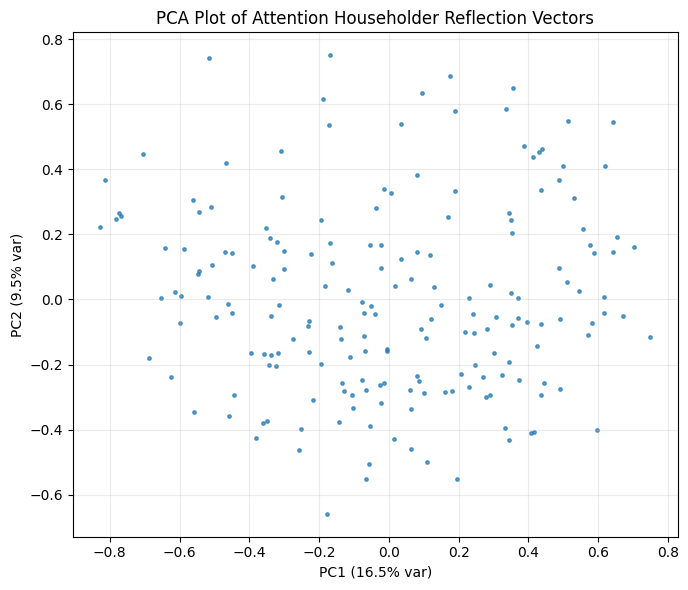

In [ ]:
attention_X_pca, attention_pca = efficient_pca(attention_hh_vecs_array,
                                    'PCA Plot of Attention Householder Reflection Vectors',
                                    'embedding_hh_vecs_pca.png',
                                    proj_dir=proj_dir,
                                    method="randomized")

In [ ]:
mlp_hh_vecs_array = np.array(mlp_hh_vecs).squeeze(axis = 1)

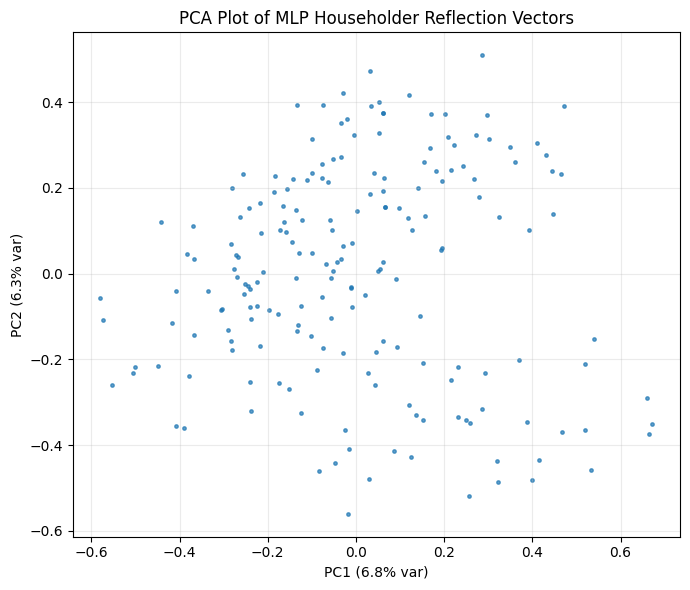

In [ ]:
mlp_X_pca, mlp_pca = efficient_pca(mlp_hh_vecs_array,
                                    'PCA Plot of MLP Householder Reflection Vectors',
                                    'attention_hh_vecs_pca.png',
                                    proj_dir=proj_dir,
                                    method="randomized")

### UMAP-based Analysis

In [ ]:
def create_vec_scatter_umap(
    vec_source,
    plt_title,
    file_name,
    color_labels = None,
    proj_dir="./QLens/",
    n_components=2,
    batch_size=10000,
    dtype=np.float32,
    plot_max_points=20000,
    random_state=42,
    # UMAP-specific
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",  # e.g., "cosine" for embeddings
    init="spectral",
    sample_fit_max=200000,  # subsample size used to fit UMAP; rest is streamed via transform
    target_metric=None,     # optional supervised embedding
    target=None,            # labels if supervised
):
    """
    Perform UMAP efficiently on large datasets and scatter-plot first two components.

    Strategy:
      - Build UMAP on a representative subsample (up to sample_fit_max).
      - Stream the remainder in batches using umap.UMAP.transform.
      - Subsample points for plotting to keep visualization responsive.

    Args:
      vec_source: one of:
        - numpy array shape (N, D)
        - list of numpy arrays (list of 2D arrays or list-of-1D arrays)
        - path to .npz files where each has 'data' = object array of per-sample vectors
      plt_title, file_name: plot title and filename (saved inside proj_dir)
      batch_size: used when reading chunks and for transform streaming
      dtype: working dtype (np.float32 recommended)
      plot_max_points: if N > plot_max_points, randomly subsample points for plotting
      UMAP hyperparams: n_neighbors, min_dist, metric, init, target_metric, target
      sample_fit_max: max number of samples to fit UMAP on (rest transformed)

    Returns:
      X_umap (N, n_components) numpy array of projected points, umap_object (fitted UMAP)
    """

    # -----------------------
    # Helper: get a generator of 2D numpy arrays (batches)
    # -----------------------
    def batch_generator_from_source(src, batch_size):
        # 1) numpy array
        if isinstance(src, np.ndarray):
            N = src.shape[0]
            for i in range(0, N, batch_size):
                yield src[i:i+batch_size].astype(dtype, copy=False)
            return

        # 2) list-like of arrays
        if isinstance(src, (list, tuple)):
            idx = 0
            while idx < len(src):
                block = src[idx:idx+batch_size]
                block2 = []
                for v in block:
                    a = np.asarray(v, dtype=dtype)
                    if a.ndim == 1:
                        a = a.reshape(1, -1)
                    block2.append(a)
                yield np.vstack(block2)
                idx += batch_size
            return

        # 3) path or glob of .npz chunk files
        if isinstance(src, str) and os.path.exists(src):
            if os.path.isfile(src) and src.endswith(".npz"):
                npz_files = [src]
            elif os.path.isdir(src):
                npz_files = sorted([os.path.join(src, f) for f in os.listdir(src) if f.endswith(".npz")])
            else:
                raise ValueError("vec_source string must be a .npz file or directory containing .npz files")

            for fn in npz_files:
                data = np.load(fn, allow_pickle=True)["data"]
                arrs = [
                    np.asarray(x, dtype=dtype).reshape(1, -1) if np.asarray(x).ndim == 1
                    else np.asarray(x, dtype=dtype)
                    for x in data
                ]
                idx = 0
                while idx < len(arrs):
                    block = arrs[idx:idx+batch_size]
                    yield np.vstack(block)
                    idx += batch_size
            return

        raise ValueError("Unsupported vec_source type")

    # -----------------------
    # First pass: gather a fitting subsample
    # -----------------------
    fit_blocks = []
    fit_count = 0
    for block in batch_generator_from_source(vec_source, batch_size):
        block = check_array(block, dtype=dtype, ensure_2d=True)
        remaining = sample_fit_max - fit_count
        if remaining <= 0:
            break
        if block.shape[0] <= remaining:
            fit_blocks.append(block)
            fit_count += block.shape[0]
        else:
            fit_blocks.append(block[:remaining])
            fit_count += remaining
            break

    if fit_count == 0:
        raise ValueError("No data found for fitting UMAP.")

    X_fit = np.vstack(fit_blocks)

    # Optional supervised setup
    y_fit = None
    if target is not None:
        # If target is provided as array aligned with vec_source, we need the corresponding subset for X_fit.
        # For large inputs, expect 'target' as a numpy array aligned to the full dataset.
        # We'll mirror the same subsampling indices used above by recomputing them deterministically.
        # To keep things simple, if target is a numpy array and vec_source is a numpy array, we slice it.
        if isinstance(vec_source, np.ndarray) and isinstance(target, np.ndarray):
            y_fit = target[:X_fit.shape[0]]
        else:
            # If targets come batched, user should pre-align and provide the subset to y_fit directly.
            y_fit = target

    # -----------------------
    # Fit UMAP on subsample
    # -----------------------
    umap_obj = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        init=init,
        random_state=random_state,
        transform_seed=random_state,
        target_metric=target_metric,
        verbose=False,
    )

    umap_obj.fit(X_fit, y=y_fit)

    # -----------------------
    # Second pass: stream-transform all data
    # -----------------------
    transformed_blocks = []
    for block in batch_generator_from_source(vec_source, batch_size):
        block = check_array(block, dtype=dtype, ensure_2d=True)
        transformed = umap_obj.transform(block)
        transformed_blocks.append(transformed)

    X_umap = np.vstack(transformed_blocks)

    # -----------------------
    # Plot: subsample if huge
    # -----------------------
    N = X_umap.shape[0]
    if N > plot_max_points:
        rng = np.random.default_rng(random_state)
        keep = rng.choice(N, size=plot_max_points, replace=False)
        plot_pts = X_umap[keep]
    else:
        plot_pts = X_umap

    plt.figure(figsize=(7, 6))

    # Determining whether to use color labels
    if color_labels is None:
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], alpha=0.7, s=6)
    else:
        plt.scatter(plot_pts[:, 0], plot_pts[:, 1], c=color_labels, cmap='tab20', alpha=0.7, s=6)

    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    plt.title(plt_title)
    plt.grid(alpha=0.25)
    plt.tight_layout()

    os.makedirs(proj_dir, exist_ok=True)
    outpath = os.path.join(proj_dir, file_name)
    plt.savefig(outpath)
    plt.show()

    return X_umap, umap_obj

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


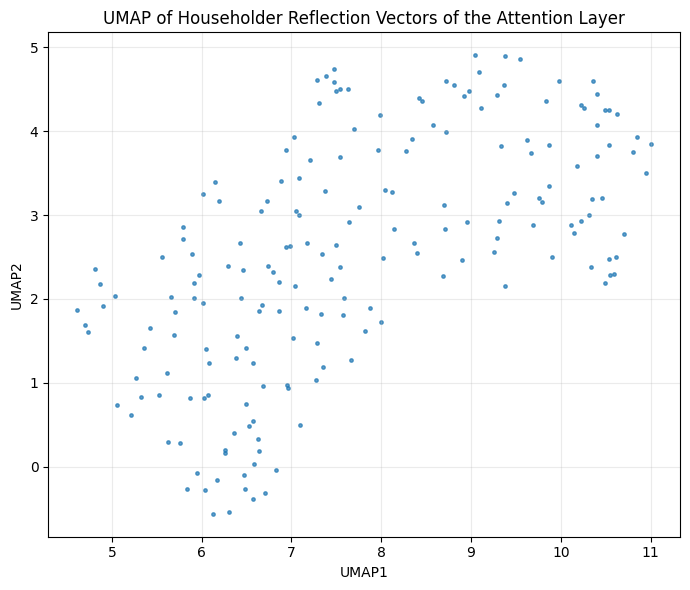

In [ ]:
attention_X_umap, attention_umap = create_vec_scatter_umap(attention_hh_vecs_array,
                                                           'UMAP of Householder Reflection Vectors of the Attention Layer',
                                                           'attention_hh_vecs_umap.png',
                                                           proj_dir = proj_dir)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


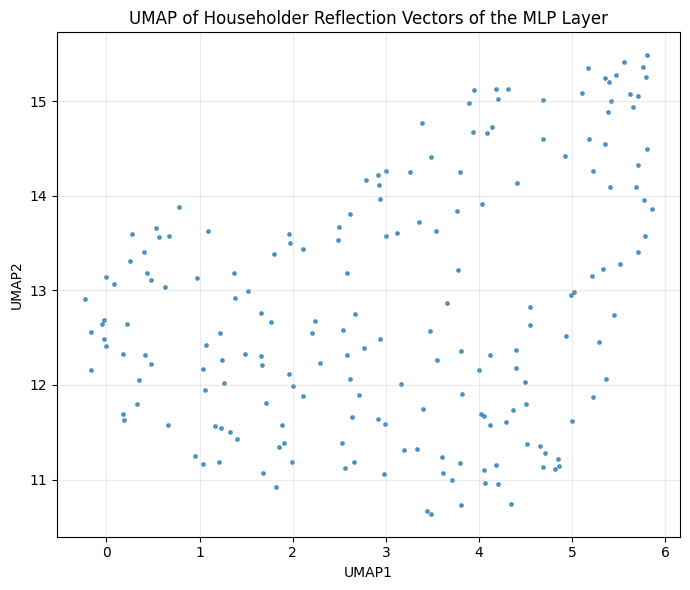

In [ ]:
mlp_X_umap, mlp_umap = create_vec_scatter_umap(mlp_hh_vecs_array,
                                              'UMAP of Householder Reflection Vectors of the MLP Layer',
                                              'mlp_hh_vecs_umap.png',
                                              proj_dir = proj_dir)

### Colored UMAP

#### Attention Layer

In [ ]:
pca_dims = 100
attention_hh_vecs_X_cluster_pca, attention_hh_vecs_cluster_pca = efficient_pca(attention_hh_vecs_array,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = pca_dims)

# Explained variance check
attention_hh_vecs_ex_var_ratio = attention_hh_vecs_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {pca_dims} dimensions: {(attention_hh_vecs_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 100 dimensions: 96.0201%


In [ ]:
def elbow_plot_analysis(data, plt_title, file_name, min_clusters = 5, max_clusters = 100, step = 1, random_state = 42):
    cluster_range = range(min_clusters, max_clusters + 1, step)

    inertia_values = []

    print(f"Starting MiniBatchKMeans fitting for number of clusters between {min_clusters} and {max_clusters}...")

    for n_clusters in tqdm(cluster_range, desc = 'Fitting clusters'):
        # Initializing MiniBatchKMeans with the current n_clusters
        kmeans = MiniBatchKMeans(
            n_clusters=n_clusters,
            random_state=random_state,
            n_init='auto',
            max_iter=30,
            verbose=0
        )

        # Fitting the model to the data
        kmeans.fit(data)

        # Appending the inertia to the list
        inertia_values.append(kmeans.inertia_)

    # Creating elbow plot
    plt.figure(figsize=(10, 6))

    # Plotting the inertia values
    plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='blue')

    # Adding labels and title
    plt.xlabel('Number of Clusters', fontsize=14)
    plt.ylabel('Total Inertia', fontsize=14)
    plt.title(plt_title, fontsize=16)

    # Formating for readability
    plt.xticks(np.arange(min_clusters, max_clusters + 1, 10))
    plt.yticks(np.arange(0, max(inertia_values) + 1, 10))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Saving plot
    plt.savefig(os.path.join(proj_dir, file_name))

    # Displaying plot
    plt.show()

Starting MiniBatchKMeans fitting for number of clusters between 5 and 100...


Fitting clusters: 100%|██████████| 96/96 [00:02<00:00, 41.79it/s]


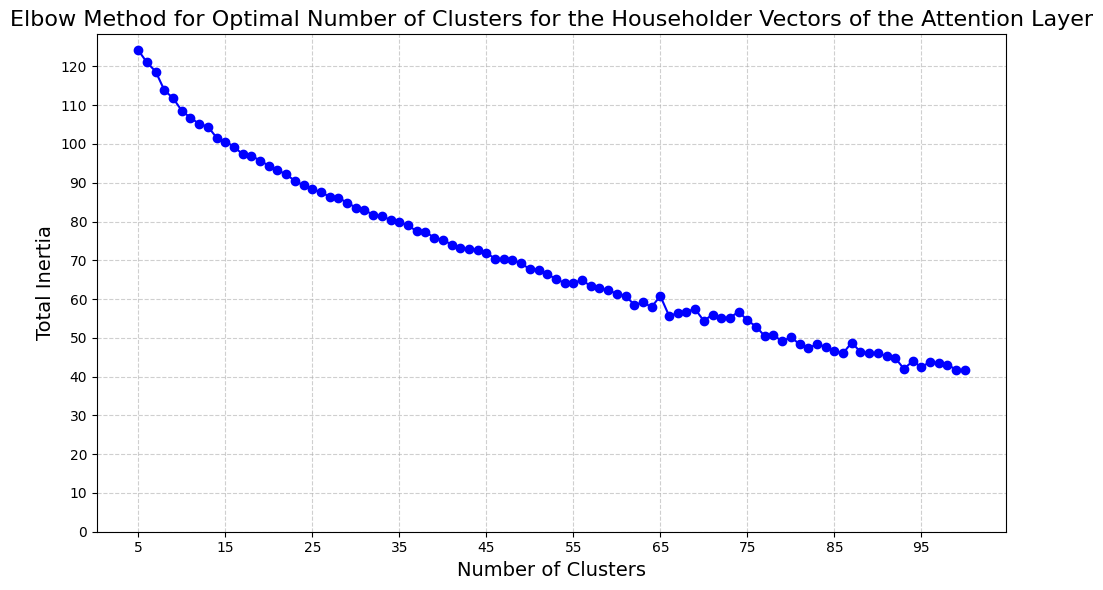

In [ ]:
# Creating elbow plot for the Householder Vectors of the Attention Layer
elbow_plot_analysis(attention_hh_vecs_X_cluster_pca,
                    'Elbow Method for Optimal Number of Clusters for the Householder Vectors of the Attention Layer',
                    'elbow_attention_hh_vecs.png')

In [ ]:
attention_hh_vecs_X_cluster_pca = attention_hh_vecs_X_cluster_pca.astype('float64')

n_clusters_attention = 31
random_state_val = 42 # Set a random state for reproducibility

# Initializing MiniBatchKMeans
attention_hh_vecs_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters_attention,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
attention_hh_vecs_kmeans.fit(attention_hh_vecs_X_cluster_pca)

# Assigning each point to cluster
attention_hh_vecs_color_labels = attention_hh_vecs_kmeans.predict(attention_hh_vecs_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 126.17908863507301
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 1/30: mean batch inertia: 0.6607719840563607
Minibatch step 2/30: mean batch inertia: 0.49408767803942916, ewa inertia: 0.49408767803942916
Minibatch step 3/30: mean batch inertia: 0.4644939421641027, ewa inertia: 0.4644939421641027
Minibatch step 4/30: mean batch inertia: 0.4476976522758081, ewa inertia: 0.4476976522758081
Minibatch step 5/30: mean batch inertia: 0.4374244498849778, ewa inertia: 0.4374244498849778
Minibatch step 6/30: mean batch inertia: 0.4533663206970226, ewa inertia: 0.4533663206970226
Minibatch step 7/30: mean batch inertia: 0.43341734898546924, ewa inertia: 0.43341734898546924
Minibatch step 8/30: mean batch inertia: 0.4444348343914122, ewa inertia: 0.4444348343914122
Minibatch step 9/30: mean batch inertia: 0.4302364201812263, ewa inertia: 0.4302364201812263
Minibatch step 10/30: mean batch inertia: 0.47399145067555165, ewa iner

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


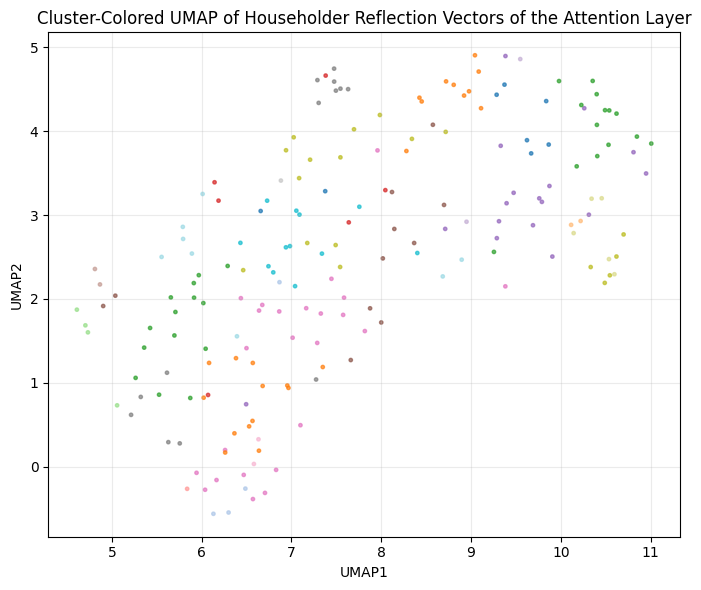

In [ ]:
attention_clustered_hh_vecs_X_umap, attention_clustered_hh_vecs_umap = create_vec_scatter_umap(attention_hh_vecs_array,
                                                                              'Cluster-Colored UMAP of Householder Reflection Vectors of the Attention Layer',
                                                                              'attention_hh_vecs_clustered_umap.png',
                                                                              attention_hh_vecs_color_labels,
                                                                              proj_dir = proj_dir)

##### Cluster Analysis

In [ ]:
# Creating mapping from item IDs to titles
id_to_title = {v:k for k,v in title_to_id.items()}

In [ ]:
def cluster_analysis(vec_array, labels, n_clusters):
    mean_cluster_cos_sims = []

    for cluster_id in range(n_clusters):
        cluster_indexes = np.where(labels == cluster_id)[0]
        cluster_vecs = vec_array[cluster_indexes, :]

        mean_cluster_vec = cluster_vecs.mean(axis=0)

        mean_cluster_vec_vals, mean_cluster_vec_item_idxs = torch.topk(torch.from_numpy(mean_cluster_vec), k = 10)

        print('Cluster ID: ', cluster_id)

        # Printing largest contributors to the average cluster Householder vector
        for k in range(mean_cluster_vec_vals.shape[0]):
            print(f'ID: {mean_cluster_vec_item_idxs[k]}, Title: {id_to_title[mean_cluster_vec_item_idxs[k].item()]}, Value: {mean_cluster_vec_vals[k]}')

        # Computing the mean cosine similarity between embeddings of the top titles in the average cluster Householder vector
        cluster_cosine_sims = []
        for i in range(mean_cluster_vec_vals.shape[0]):
            id_1 = mean_cluster_vec_item_idxs[i]

            with torch.no_grad():
                embed_1 = model.compression(model.embedding(torch.tensor([id_1], device = device)))

                for j in range(i + 1, mean_cluster_vec_vals.shape[0]):
                    id_2 = mean_cluster_vec_item_idxs[j]
                    embed_2 = model.compression(model.embedding(torch.tensor([id_2], device = device)))

                    cos_sim = nn.functional.cosine_similarity(embed_1, embed_2)
                    cluster_cosine_sims.append(cos_sim)

        mean_cluster_cosine_sim = sum(cluster_cosine_sims) / len(cluster_cosine_sims)
        mean_cluster_cos_sims.append(mean_cluster_cosine_sim)

        print('\n')
        print(f'Mean Cluster Embedding Cosine Similarity: {mean_cluster_cosine_sim.item():.4f}')
        print('---\n')

    return mean_cluster_cos_sims

In [ ]:
# Attention cluster analysis - searching for cohesion in attention clusters
attention_mean_cluster_cos_sims = cluster_analysis(attention_hh_vecs_array,
                                                  attention_hh_vecs_color_labels,
                                                  n_clusters_attention)

Cluster ID:  0
ID: 5388, Title: Cache a Predator: A Geocaching Mystery, Value: 0.04027577117085457
ID: 2089, Title: For You, Value: 0.04025120660662651
ID: 4279, Title: Maisy and the Missing Mice (The Maisy Files) (Volume 1), Value: 0.035913851112127304
ID: 1950, Title: Polio: An American Story, Value: 0.03526293486356735
ID: 5263, Title: The Bosshole Effect: Three Simple Steps Anyone Can Follow to Become a Great Boss and Lead a Successful Team, Value: 0.034823670983314514
ID: 3309, Title: Jokes for Kids: Jokes, Riddles, &amp; Tongue Twisters That Will Tickle Your Ribs &amp; Make Your Funny Bone Laugh, Value: 0.03416287526488304
ID: 2277, Title: Achieve Anything in Just One Year: Be Inspired Daily to Live Your Dreams and Accomplish Your Goals, Value: 0.03323150426149368
ID: 2407, Title: Forsaken: The World of Nightwalkers, Value: 0.031826142221689224
ID: 3011, Title: Bankroll Squad *Official*, Value: 0.03180817887187004
ID: 3977, Title: Man and His Symbols, Value: 0.03139427304267883



In [ ]:
mean_attention_cluster_cos_sim_cohesion = sum(attention_mean_cluster_cos_sims) / len(attention_mean_cluster_cos_sims)
print(f'Mean Attention Cluster Cohesion (via Cosine Similarity between Title Embeddings): {mean_attention_cluster_cos_sim_cohesion.item():.4f}')

Mean Attention Cluster Cohesion (via Cosine Similarity between Title Embeddings): 0.1586


In [ ]:
def get_mean_rand_cluster_embedding_sim(layer_hh_vecs, orig_labels, n_clusters, k = 10):
    rand_cluster_cos_sims = []
    rand_labels = np.random.permutation(orig_labels)

    for rand_cluster_id in range(n_clusters):
        rand_idxs = np.where(rand_labels == rand_cluster_id)[0]
        rand_cluster_vecs = layer_hh_vecs[rand_idxs, :]

        mean_cluster_hh_vec = rand_cluster_vecs.mean(axis = 0)
        mean_cluster_hh_vec_vals, mean_cluster_hh_vec_item_idxs = torch.topk(torch.from_numpy(mean_cluster_hh_vec), k = k)

        cluster_cosine_sims = []
        for i in range(mean_cluster_hh_vec_vals.shape[0]):
            id_1 = mean_cluster_hh_vec_item_idxs[i]

            with torch.no_grad():
                embed_1 = model.compression(model.embedding(torch.tensor([id_1], device = device)))

                for j in range(i + 1, mean_cluster_hh_vec_vals.shape[0]):
                    id_2 = mean_cluster_hh_vec_item_idxs[j]
                    embed_2 = model.compression(model.embedding(torch.tensor([id_2], device = device)))

                    cos_sim = nn.functional.cosine_similarity(embed_1, embed_2)
                    cluster_cosine_sims.append(cos_sim)

        mean_cluster_cosine_sim = sum(cluster_cosine_sims) / len(cluster_cosine_sims)
        rand_cluster_cos_sims.append(mean_cluster_cosine_sim)

    mean_rand_cluster_cos_sim = sum(rand_cluster_cos_sims) / len(rand_cluster_cos_sims)

    return mean_rand_cluster_cos_sim.item()

In [ ]:
# Comparing cohesion in Attention clusters against random baseline
mean_attention_rand_cluster_embedding_sim = get_mean_rand_cluster_embedding_sim(attention_hh_vecs_array,
                                                                                attention_hh_vecs_color_labels,
                                                                                n_clusters_attention)

print(f'Random Baseline for Attention Cluster Cohesion: {mean_attention_rand_cluster_embedding_sim:.4f}')

Random Baseline for Attention Cluster Cohesion: 0.1319


In [ ]:
def cluster_cohesion_test(test_vecs, test_labels, test_clusters, test_value, n_trials = 100):
    count = 0
    for trial in tqdm(range(n_trials), desc = 'Running permutations'):
        rand_cluster_cohesion = get_mean_rand_cluster_embedding_sim(attention_hh_vecs_array,
                                                                    attention_hh_vecs_color_labels,
                                                                    n_clusters_attention)

        if rand_cluster_cohesion > test_value:
            count += 1

    p_val = (count + 1) / (n_trials + 1) # Plus one-smoothing is used

    return p_val

In [ ]:
# Computing P-value of attention hh_vecs cohesion against randomized baseline
attention_hh_vecs_cohesion_p_val = cluster_cohesion_test(attention_hh_vecs_array,
                                                        attention_hh_vecs_color_labels,
                                                        n_clusters_attention,
                                                        mean_attention_cluster_cos_sim_cohesion.item())
print(f'Attention Householder Reflection Vectors Cluster Cohesion P-value: {attention_hh_vecs_cohesion_p_val:.4f}')

Attention Householder Reflection Vectors Cluster Cohesion P-value: 0.0099


#### MLP Layer

In [ ]:
mlp_hh_vecs_X_cluster_pca, mlp_hh_vecs_cluster_pca = efficient_pca(mlp_hh_vecs_array,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = pca_dims)

# Explained variance check
mlp_hh_vecs_ex_var_ratio = mlp_hh_vecs_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {pca_dims} dimensions: {(mlp_hh_vecs_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 100 dimensions: 94.8116%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 100...


Fitting clusters: 100%|██████████| 96/96 [00:02<00:00, 43.12it/s]


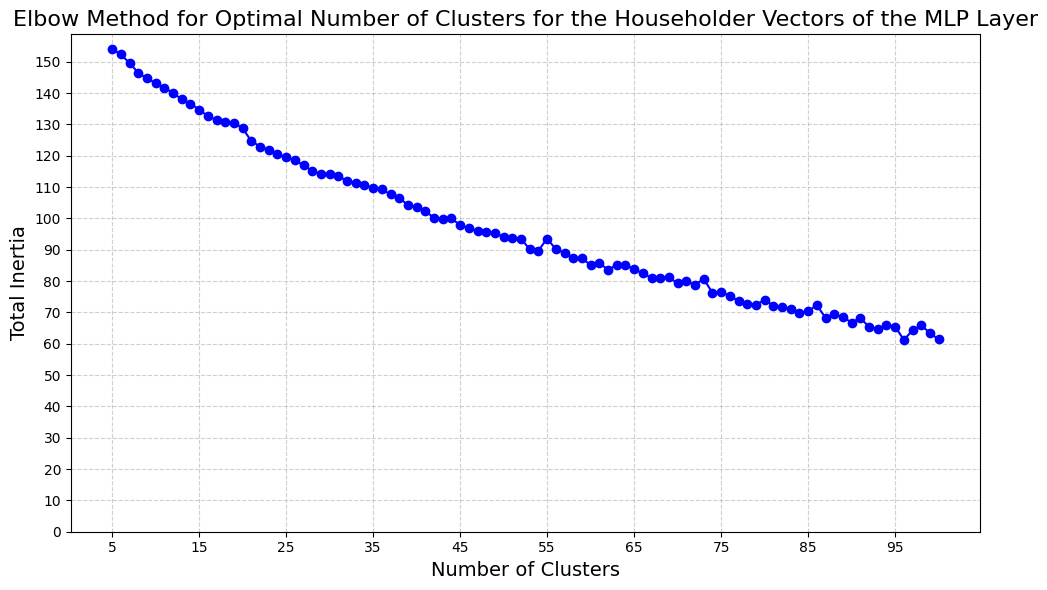

In [ ]:
# Creating elbow plot for the Householder Vectors of the MLP Layer
elbow_plot_analysis(mlp_hh_vecs_X_cluster_pca,
                    'Elbow Method for Optimal Number of Clusters for the Householder Vectors of the MLP Layer',
                    'elbow_mlp_hh_vecs.png')

In [ ]:
mlp_hh_vecs_X_cluster_pca = mlp_hh_vecs_X_cluster_pca.astype('float64')

n_clusters_mlp = 45

# Initializing MiniBatchKMeans
mlp_hh_vecs_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters_mlp,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
mlp_hh_vecs_kmeans.fit(mlp_hh_vecs_X_cluster_pca)

# Assigning each point to cluster
mlp_hh_vecs_color_labels = mlp_hh_vecs_kmeans.predict(mlp_hh_vecs_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 155.68095904280528
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch step 1/30: mean batch inertia: 0.871957342199838
Minibatch step 2/30: mean batch inertia: 0.5827580677516285, ewa inertia: 0.5827580677516285
Minibatch step 3/30: mean batch inertia: 0.560696026628382, ewa inertia: 0.560696026628382
Minibatch step 4/30: mean batch inertia: 0.5580716178433025, ewa inertia: 0.5580716178433025
Minibatch step 5/30: mean batch inertia: 0.5207782477178177, ewa inertia: 0.5207782477178177
Minibatch step 6/30: mean batch inertia: 0.5677491678505998, ewa inertia: 0.5677491678505998
Minibatch step 7/30: mean batch inertia: 0.5140431663288147, ewa inertia: 0.5140431663288147
Minibatch step 8/30: mean batch inertia: 0.5322855096609133, ewa inertia: 0.5322855096609133
Minibatch step 9/30: mean batch inertia: 0.509223242564752, ewa inertia: 0.509223242564752
Minibatch step 10/30: mean batch inertia: 0.5094243047140663, ewa inertia: 0.509

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


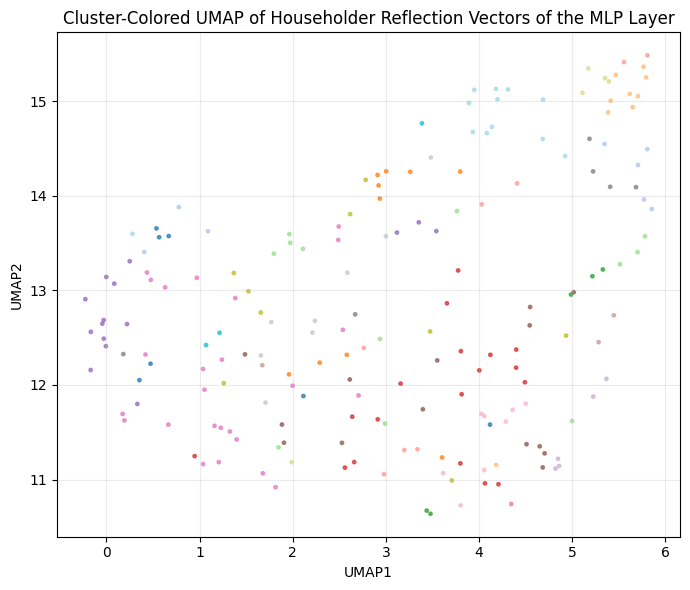

In [ ]:
mlp_clustered_hh_vecs_X_umap, mlp_clustered_hh_vecs_umap = create_vec_scatter_umap(mlp_hh_vecs_array,
                                                                              'Cluster-Colored UMAP of Householder Reflection Vectors of the MLP Layer',
                                                                              'mlp_hh_vecs_clustered_umap.png',
                                                                              mlp_hh_vecs_color_labels,
                                                                              proj_dir = proj_dir)

##### Cluster Cohesion

In [ ]:
# MLP cluster analysis - searching for cohesion in MLP clusters
mlp_mean_cluster_cos_sims = cluster_analysis(mlp_hh_vecs_array,
                                            mlp_hh_vecs_color_labels,
                                            n_clusters_mlp)

Cluster ID:  0
ID: 362, Title: Unbreakable, Value: 0.07414954155683517
ID: 4041, Title: Lady Justice and the Assassin, Value: 0.07203637063503265
ID: 3116, Title: A Week to Be Wicked (Spindle Cove), Value: 0.07104597240686417
ID: 957, Title: Flowers for Algernon, Value: 0.06796031445264816
ID: 2382, Title: A Hidden Fire: Elemental Mysteries Book 1, Value: 0.06474107503890991
ID: 1480, Title: The Doctor's Secret Bride (Billionaire Brides of Granite Falls) (Volume 1), Value: 0.06018717586994171
ID: 2826, Title: Reign of Blood, Value: 0.05697550252079964
ID: 1649, Title: Candy Store, Value: 0.05503986030817032
ID: 42, Title: Tangled (The Tangled Series), Value: 0.054102279245853424
ID: 155, Title: Rules of Entanglement (A Fighting for Love Novel), Value: 0.053798381239175797


Mean Cluster Embedding Cosine Similarity: 0.0752
---

Cluster ID:  1
ID: 2527, Title: The Ascent of Money: A Financial History of the World, Value: 0.05817413330078125
ID: 1063, Title: Getting to Yes: Negotiation Sk

In [ ]:
mean_mlp_cluster_cos_sim_cohesion = sum(mlp_mean_cluster_cos_sims) / len(mlp_mean_cluster_cos_sims)
print(f'Mean MLP Cluster Cohesion (via Cosine Similarity between Title Embeddings): {mean_mlp_cluster_cos_sim_cohesion.item():.4f}')

Mean MLP Cluster Cohesion (via Cosine Similarity between Title Embeddings): 0.1429


In [ ]:
# Comparing semantic cohesion in MLP clusters against random baseline
mean_mlp_rand_cluster_embedding_sim = get_mean_rand_cluster_embedding_sim(mlp_hh_vecs_array,
                                                                          mlp_hh_vecs_color_labels,
                                                                          n_clusters_mlp)

print(f'Random Baseline for MLP Cluster Cohesion: {mean_mlp_rand_cluster_embedding_sim:.4f}')

Random Baseline for MLP Cluster Cohesion: 0.1222


In [ ]:
# Computing P-value of attention hh_vecs cohesion against randomized baseline
mlp_hh_vecs_cohesion_p_val = cluster_cohesion_test(mlp_hh_vecs_array,
                                                  mlp_hh_vecs_color_labels,
                                                  n_clusters_mlp,
                                                  mean_mlp_cluster_cos_sim_cohesion.item())
print(f'MLP Householder Reflection Vectors Cluster Cohesion P-value: {mlp_hh_vecs_cohesion_p_val:.4f}')

MLP Householder Reflection Vectors Cluster Cohesion P-value: 0.3069


## Frobenius Similarities

### Creating Histograms

In [ ]:
def householder_mean_cosine_hist(
    V,
    bins=50,
    device=None,
    chunk_size=None,
    title="Mean pairwise Frobenius cosine similarity (Householder)",
    show=True,
):
    """
    Compute a histogram of the mean pairwise Frobenius cosine similarity between
    unitary Householder operators H_i = I - 2 v_i v_i^* constructed from input
    reflection vectors v_i. Uses a closed-form to avoid building H explicitly.

    Key identity (real or complex):
      ||H||_F^2 = d  (since H is unitary/orthogonal)
      tr(H_i^* H_j) = d - 4 + 4 |<v_i, v_j>|^2
      cosine(H_i, H_j) = tr(H_i^* H_j) / (||H_i||_F ||H_j||_F) = (d - 4 + 4 |<v_i, v_j>|^2) / d

    Args:
      V: numpy array or torch tensor of shape (n, d). Real or complex.
         Each row is a Householder reflection vector (need not be normalized).
      bins: number of bins in the histogram.
      device: torch device (e.g., "cuda", "cpu"). If None, auto-select CUDA if available.
      chunk_size: optional int to compute the Gram matrix in chunks when n is very large.
      title: plot title.
      show: if True, shows the plot; otherwise returns data for custom plotting.

    Returns:
      means: numpy array shape (n,) with mean cosine similarity per operator (excluding self).
      hist: (counts, bin_edges) from numpy.histogram.
    """
    # Move to torch
    if isinstance(V, np.ndarray):
        # Preserve dtype (including complex)
        tV = torch.from_numpy(V)
    elif isinstance(V, torch.Tensor):
        tV = V
    else:
        raise TypeError("V must be a numpy array or torch tensor")

    # Select device
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    tV = tV.to(device)

    # Normalize vectors to unit norm along rows
    # For complex: use conjugate norm properly
    # eps guards against zero vectors
    eps = torch.tensor(1e-12, dtype=tV.real.dtype, device=device)
    if torch.is_complex(tV):
        norms = torch.linalg.vector_norm(tV, dim=1)
    else:
        norms = torch.linalg.vector_norm(tV, dim=1)
    tV = tV / (norms.clamp_min(eps).unsqueeze(1))

    n, d = tV.shape

    # Compute Gram matrix of inner products G_ij = <v_i, v_j>
    # For complex: use conjugate inner product
    # If n is large, optionally chunk to limit memory.
    def gram_chunked(V, chunk_size):
        # Returns full Gram matrix G of shape (n, n)
        if chunk_size is None:
            if torch.is_complex(V):
                G = V @ V.conj().T
            else:
                G = V @ V.T
            return G
        else:
            G = torch.empty((n, n), dtype=V.dtype, device=V.device)
            for i in range(0, n, chunk_size):
                Vi = V[i:i+chunk_size]
                if torch.is_complex(Vi):
                    Gi = Vi @ V.conj().T
                else:
                    Gi = Vi @ V.T
                G[i:i+chunk_size] = Gi
            return G

    G = gram_chunked(tV, chunk_size)

    # Frobenius cosine using identity:
    # cosine_ij = (d - 4 + 4 * |G_ij|^2) / d
    absG2 = (G.abs() ** 2) if torch.is_complex(G) else (G ** 2)
    cos_mat = (d - 4.0 + 4.0 * absG2) / float(d)

    # Exclude diagonal for mean per operator
    # Replace diagonal with NaN then compute nanmean across axis
    cos_mat.fill_diagonal_(float("nan"))
    means = torch.nanmean(cos_mat, dim=1)

    # Move to CPU numpy
    means_np = means.detach().cpu().numpy()

    # Histogram
    counts, edges = np.histogram(means_np, bins=bins)

    # Plot
    if show:
        plt.figure(figsize=(7, 5))
        plt.hist(means_np, bins=bins, alpha=0.85, color="#4C78A8", edgecolor="white")
        plt.title(title)
        plt.xlabel("Mean pairwise Frobenius cosine similarity")
        plt.ylabel("Count")
        plt.grid(alpha=0.25)
        plt.tight_layout()
        plt.show()

    return means_np, (counts, edges)

In [ ]:
def compute_fro_sim(vec_array, title, device, bins = 10, sample_size = None):
    vec_array = torch.from_numpy(vec_array)

    if sample_size is None:
        sample_size = vec_array.shape[0]

    all_idxs = list(range(vec_array.shape[0]))
    random.shuffle(all_idxs)
    sample_idxs = all_idxs[:sample_size]

    fro_sims = []
    for i in range(len(sample_idxs)):
        for j in range(i + 1, len(sample_idxs)):
            vec_1 = vec_array[sample_idxs[i], :].squeeze(0).to(device)
            vec_2 = vec_array[sample_idxs[j], :].squeeze(0).to(device)
            inner_prod = torch.inner(vec_1, vec_2).item()

            sim = 1 - (4 / vec_array.shape[1]) + ((4  * (inner_prod ** 2)) / vec_array.shape[1])

            fro_sims.append(sim)

    mean_sim = sum(fro_sims) / len(fro_sims)

    plt.figure(figsize=(7, 5))
    plt.hist(fro_sims, bins=bins, alpha=0.85, color="#4C78A8", edgecolor="white")
    plt.xlim(-1.1, 1.1)

    plt.title(title)
    plt.xlabel("Pairwise Frobenius cosine similarity")
    plt.ylabel("Count")

    plt.axvline(mean_sim, color='red', linestyle='dashed', linewidth=2, label=f'Mean Similarity: {mean_sim:.2f}')
    plt.legend()

    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

    return fro_sims

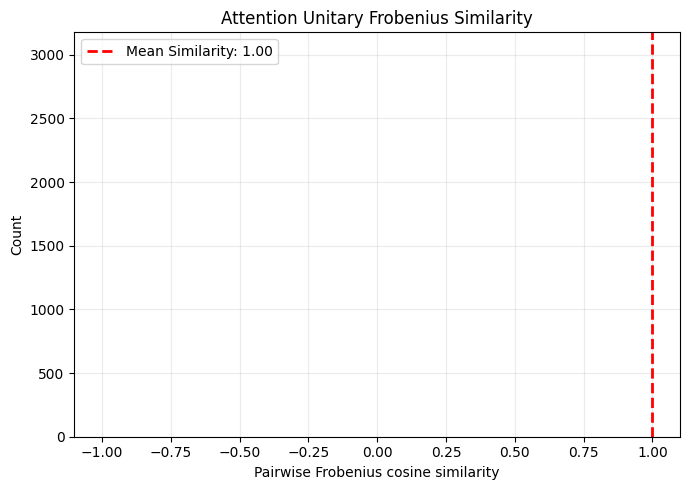

In [ ]:
attention_fro_sims = compute_fro_sim(attention_hh_vecs_array,
                    device = device,
                    title = 'Attention Unitary Frobenius Similarity',
                    sample_size = 100)

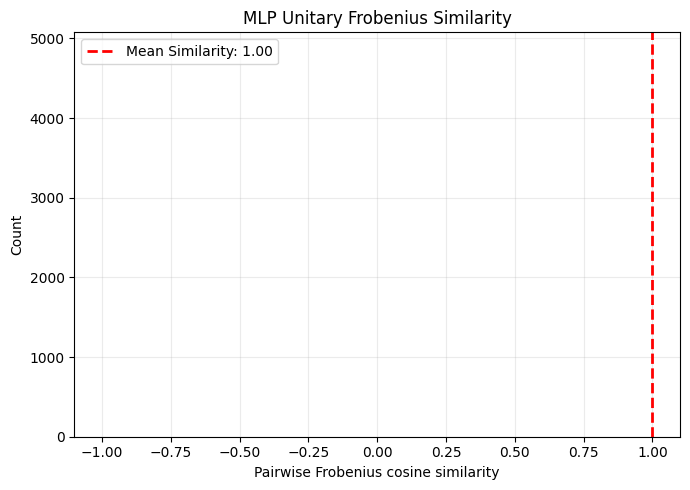

In [ ]:
mlp_fro_sims = compute_fro_sim(mlp_hh_vecs_array,
                    device = device,
                    title = 'MLP Unitary Frobenius Similarity',
                    sample_size = 100)

In [ ]:
def get_random_hh_vecs(dim_vecs, num_vecs):
    phi_0_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_0_vecs = phi_0_vecs / np.linalg.norm(phi_0_vecs, axis=1, keepdims=True)

    phi_1_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_1_vecs = phi_1_vecs / np.linalg.norm(phi_1_vecs, axis=1, keepdims=True)

    hh_vecs = []
    for i in range(phi_0_vecs.shape[0]):
        hh = phi_1_vecs[i, :] - phi_0_vecs[i, :]
        hh = hh / np.linalg.norm(hh)

        hh_vecs.append(hh)

    hh_vecs = np.asarray(hh_vecs)

    return hh_vecs

In [ ]:
rand_hh_vecs = get_random_hh_vecs(mlp_hh_vecs_array.shape[1], 100)

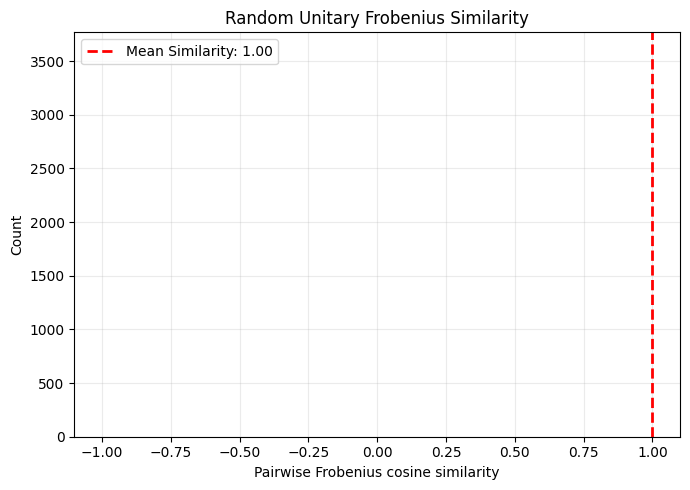

In [ ]:
rand_fro_sims = compute_fro_sim(rand_hh_vecs,
                                device = device,
                                title = 'Random Unitary Frobenius Similarity',
                                sample_size = 100)

### Permutation Tests for the Frobenius Similarity of Unitary Operators

In [ ]:
'''
mean_from_sim_submatrix() returns the mean pairwise similarity
computed from an input simularity (or Gram) submatrix.

    Args:
        sim_submatrix (torch.Tensor): Square matrix to compute mean similarities from.

    Returns:
        (float): Mean pairwise similarity from the input matrix.
'''
def mean_from_sim_submatrix(sim_submatrix: torch.Tensor) -> float:

    # Shape check
    n = sim_submatrix.shape[0]
    if n < 2:
        return float("nan")

    # Summing unique off-diagonal elements to get all unique pairwise similarities
    # All entries with row < collumn are effectiely summed
    total = sim_submatrix.sum()
    diag = sim_submatrix.diag().sum()
    sum_offdiag = (total - diag) / 2.0

    # Total number of elements
    denom = n * (n - 1) / 2.0

    return (sum_offdiag / denom).item()

'''
permutation_test_precompute() conducts a permutation test to determine the
statistical significance of an observed difference in mean pairwise Frobenius
cosine similarities between unitary operators or Hamiltonians dervided from a
test set of Householder reflection vectors and a random baseline using GPU
(if available).

    Args:
        pooled_numpy (numpy.ndarray): N by d array of test set vectors concatenated
                                      with that of the random baseline.
        n_test (int): Number of test set vectors located at the start of the
                      pooled_numpy array.
        test_unitaries (bool, optional): Whether to conduct test of unitary operators
                                         (True) or Hamiltonians (False), defaults to True.
        device (str, optional): Sets the device to run test on, defaults to 'cuda'.
        n_perms (int, optional): Number of permutations to run in the permutation test,
                                 defaults to 1000.
        two_sided (bool, optional): Whether to conduct a two_sided permutation test,
                                    defaults to True.
        seed (int, optional): Random seed to use, defaults to 42.
        dtype (torch.dtype, optional): Sets dtype used by torch, defaults to torch.float64.
        verbose (bool, optional): If True, prints the observed mean pairwise similarities
                                  from the test vectors and random baseline vectors,
                                  defaults to False.

    Returns:
        obs_diff (float): Observed difference in mean pairwise similarities between
                          the test vectors and the random baseline.
        pval (float): P-value obtained by the conducted permutation test.
'''
def permutation_test_precompute(pooled_numpy, n_test, test_unitaries = True, device='cuda', n_perms=1000,
                                two_sided=True, seed=42, dtype=torch.float64, verbose = False):
    """
    pooled_numpy : (N, d) numpy array
    n_test       : number of samples in group A (first group size)
    """
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)

    device = torch.device(device)
    pooled = torch.from_numpy(pooled_numpy).to(device=device, dtype=dtype)

    N, d = pooled.shape
    # Computing the Gram matrix of inner products in float32 on GPU
    with torch.no_grad():
        Gram = pooled @ pooled.t()  # Shape: (N, N)

        # Converting Gram matrix to that of frobenius cosine similarities
        denom = float(d)

        if test_unitaries:
            # Unitary-operator-based similarity
            Sim = (1.0 - (4.0 / denom)) + (4.0 / denom) * (Gram * Gram)
        else:
            # Hamiltonian-based similarity
            Sim = (Gram * Gram)

    # Computing the observed difference
    mean_a = mean_from_sim_submatrix(Sim[:n_test, :n_test])
    mean_b = mean_from_sim_submatrix(Sim[n_test:, n_test:])

    obs_diff = mean_a - mean_b

    if verbose:
        # Printing Layer and Baseline Similarities
        print('Mean Frobenius Cosine Similarity for Layer: ', mean_a)
        print('Mean Frobenius Cosine Similarity for Random Baseline: ', mean_b)

    perm_diffs = np.empty(n_perms, dtype=float)
    # Permute indices on CPU but indexing Sim happens on GPU
    for t in range(n_perms):
        perm_idx = rng.permutation(N)
        idx_a = perm_idx[:n_test]
        idx_b = perm_idx[n_test:]

        # Slicing Sim to capture permutated indexes
        sim_a = Sim[idx_a][:, idx_a]
        sim_b = Sim[idx_b][:, idx_b]

        perm_diffs[t] = mean_from_sim_submatrix(sim_a) - mean_from_sim_submatrix(sim_b)

    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1) # Plus one smoothing is used

    return obs_diff, pval

In [ ]:
if 1000 <= attention_hh_vecs_array.shape[0]:
    n_sample = 1000
else:
    n_sample = attention_hh_vecs_array.shape[0]

print('Sample size:', n_sample)

Sample size: 191


In [ ]:
rand_hh_vecs = get_random_hh_vecs(mlp_hh_vecs_array.shape[1], n_sample)

In [ ]:
atten_diff, atten_pval = permutation_test_precompute(np.concatenate((attention_hh_vecs_array[:n_sample, :], rand_hh_vecs), axis = 0),
                                                     n_test = n_sample,
                                                     test_unitaries = True,
                                                     verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.9993089969882681
Mean Frobenius Cosine Similarity for Random Baseline:  0.9992607662539646


In [ ]:
print(f'Attention Observed Difference: {atten_diff}\nAttention P-value: {atten_pval}')

Attention Observed Difference: 4.823073430348934e-05
Attention P-value: 0.000999000999000999


In [ ]:
mlp_diff, mlp_pval = permutation_test_precompute(np.concatenate((mlp_hh_vecs_array[:n_sample, :], rand_hh_vecs), axis = 0),
                                                 n_test = n_sample,
                                                 test_unitaries = True,
                                                 verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.999273808381082
Mean Frobenius Cosine Similarity for Random Baseline:  0.9992607662539646


In [ ]:
print(f'MLP Observed Difference: {mlp_diff}\nMLP P-value: {mlp_pval}')

MLP Observed Difference: 1.3042127117390834e-05
MLP P-value: 0.000999000999000999


### Permutation Tests for the Frobenius Similarity of Hamiltonians

In [ ]:
# ---- Mode A: Precompute pooled similarity matrix (very fast if N^2 fits in GPU mem) ----
def hamiltonian_permutation_test_precompute(pooled_numpy, n_test, device='cuda', n_perms=1000,
                                two_sided=True, seed=42, dtype=torch.float64, verbose = False):
    """
    pooled_numpy : (N, d) numpy array
    n_test       : number of samples in group A (first group size)
    """
    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)

    device = torch.device(device)
    pooled = torch.from_numpy(pooled_numpy).to(device=device, dtype=dtype)

    N, d = pooled.shape
    # compute Gram = pooled @ pooled.T (inner products) in float32 on GPU
    with torch.no_grad():
        Gram = pooled @ pooled.t() # (N, N)
        # convert Gram -> sim
        # sim = (inner_prod^2)
        denom = float(d)
        Sim = (Gram * Gram)

    # observed difference
    mean_a = mean_from_sim_submatrix(Sim[:n_test, :n_test])
    mean_b = mean_from_sim_submatrix(Sim[n_test:, n_test:])

    if verbose:
        print('Mean Frobenius Cosine Similarity for Layer: ', mean_a)
        print('Mean Frobenius Cosine Similarity for Random Baseline: ', mean_b)

    obs_diff = mean_a - mean_b

    perm_diffs = np.empty(n_perms, dtype=float)
    # Permute indices on CPU but indexing Sim happens on GPU (cheap)
    for t in range(n_perms):
        perm_idx = rng.permutation(N)
        idx_a = perm_idx[:n_test]
        idx_b = perm_idx[n_test:]

        # Use torch indexing (it will copy those rows/cols but submatrices are small relative to N)
        sim_a = Sim[idx_a][:, idx_a]
        sim_b = Sim[idx_b][:, idx_b]

        perm_diffs[t] = mean_from_sim_submatrix(sim_a) - mean_from_sim_submatrix(sim_b)

    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1)

    return obs_diff, pval

In [ ]:
atten_hamiltonian_diff, atten_hamiltonian_pval = permutation_test_precompute(np.concatenate((attention_hh_vecs_array[:n_sample, :], rand_hh_vecs), axis = 0),
                                                                            n_test = n_sample,
                                                                            test_unitaries = False,
                                                                            verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.06541842663296017
Mean Frobenius Cosine Similarity for Random Baseline:  0.00018635848715938154


In [ ]:
print(f'Attention Observed Difference for Hamiltonians: {atten_hamiltonian_diff}\nAttention P-value for Hamiltonians: {atten_hamiltonian_pval}')

Attention Observed Difference for Hamiltonians: 0.06523206814580079
Attention P-value for Hamiltonians: 0.000999000999000999


In [ ]:
mlp_hamiltonian_diff, mlp_hamiltonian_pval = permutation_test_precompute(np.concatenate((mlp_hh_vecs_array[:n_sample, :], rand_hh_vecs), axis = 0),
                                                                        n_test = n_sample,
                                                                        test_unitaries = False,
                                                                        verbose = True)

Mean Frobenius Cosine Similarity for Layer:  0.01782583541309573
Mean Frobenius Cosine Similarity for Random Baseline:  0.00018635848715938154


In [ ]:
print(f'MLP Observed Difference for Hamiltonians: {mlp_hamiltonian_diff}\nMLP P-value for Hamiltonians: {mlp_hamiltonian_pval}')

MLP Observed Difference for Hamiltonians: 0.01763947692593635
MLP P-value for Hamiltonians: 0.000999000999000999


## Analyzing Correlation between Model Layers

In [ ]:
dcor_interdependence = dcor.distance_correlation(attention_hh_vecs_array[:1000, :], mlp_hh_vecs_array[:1000, :])
print(f'Distance correlation between Attention and MLP layer Householder vectors: {dcor_interdependence:.4f}')

Distance correlation between Attention and MLP layer Householder vectors: 0.7079


In [ ]:
dcor_t_test = dcor.independence.distance_correlation_t_test(attention_hh_vecs_array[:1000, :], mlp_hh_vecs_array[:1000, :])
print(f'Distance correlation t-test for independence P Value: {dcor_t_test.pvalue:.4f}')

Distance correlation t-test for independence P Value: 0.0000


In [ ]:
dcor_covar_test = dcor.independence.distance_covariance_test(attention_hh_vecs_array[:1000, :],
                                                          mlp_hh_vecs_array[:1000, :],
                                                          num_resamples=1000,
                                                          random_state=42,
                                                        )
print(f'Distance correlation Covariance test for independence P Value: {dcor_covar_test.pvalue:.6f}')

Distance correlation Covariance test for independence P Value: 0.000999


## Analyzing Changes in State Vectors Derivied from the Hamiltonians

In [ ]:
'''
get_last_inst_delta_phis() computes change in model state vectors over a layer using
the properties of its Hamiltonian

Args:
    phi0_array (2D np.ndarray): Array of input state vectors
    hh_vecs_array (2D np.ndarray): Array of Householder reflection vectors
                                   defining the layer Hamiltonian
    alpha (float, optional): Constant to correct for scaled definition of
                             the original Hamiltonian, defaults to 1.
Returns:
    delta_phi_array (2D np.ndarray): Array of change in model state vectors
'''
def get_last_inst_delta_phis(phi0_array, hh_vecs_array, alpha = 1):

  # First dimension (S): number of sequences
  # Second dimension (V): model vocabulary size
  S, V = phi0_array.shape

  delta_phi_array = np.zeros(phi0_array.shape)

  # Looping over all sequences
  for i in range(S):
      hh_vec = hh_vecs_array[i, :]
      phi0 = phi0_array[i, :]

      # Hamiltonian is constructed with hh_vec as an eigenvector with eigenvalue pi
      eigenvalue = np.pi

      # Preparing eigenvalue_scale_factor for delta phi computation
      eigenvalue_scale_factor = (cmath.exp(1j * alpha * eigenvalue) - 1)
      eigenvalue_scale_factor = complex(round(eigenvalue_scale_factor.real, 3), round(eigenvalue_scale_factor.imag, 3))
      if eigenvalue_scale_factor.imag == 0:
          eigenvalue_scale_factor = eigenvalue_scale_factor.real

      delta_phi = eigenvalue_scale_factor * hh_vec * np.dot(hh_vec, phi0)

      delta_phi_array[i, :] = delta_phi

  return delta_phi_array

### Delta Phi Vectors Norm Calculation and Analysis

In [ ]:
# Preparing attention_ket0_vecs and attention_hh_vecs as numpy arrays
attention_ket0_vecs = np.array(attention_ket0_vecs).squeeze(axis = 1)
attention_hh_vecs = np.array(attention_hh_vecs).squeeze(axis = 1)

In [ ]:
attention_ket0_vecs.shape[0]

191

In [ ]:
attention_delta_phis = get_last_inst_delta_phis(attention_ket0_vecs, attention_hh_vecs)

In [ ]:
# Preparing mlp_ket0_vecs and mlp_hh_vecs as numpy arrays
mlp_ket0_vecs = np.array(mlp_ket0_vecs).squeeze(axis = 1)
mlp_hh_vecs = np.array(mlp_hh_vecs).squeeze(axis = 1)

In [ ]:
mlp_delta_phis = get_last_inst_delta_phis(mlp_ket0_vecs, mlp_hh_vecs)

In [ ]:
ave_attention_delta_phi = np.mean(attention_delta_phis, axis = 0)
assert ave_attention_delta_phi.shape[0] == num_items

print(f'Average Attention Delta Phi L2 Norm: {np.linalg.norm(ave_attention_delta_phi)}')

Average Attention Delta Phi L2 Norm: 0.029405143841833712


In [ ]:
ave_attention_delta_phi_vals, ave_attention_delta_idxs = torch.topk(torch.from_numpy(ave_attention_delta_phi), k = 10)

# Printing largest contributors to the average delta phi vector
for k in range(ave_attention_delta_phi_vals.shape[0]):
    print(f'ID: {ave_attention_delta_idxs[k]}, Title: {id_to_title[ave_attention_delta_idxs[k].item()]}, Value: {ave_attention_delta_phi_vals[k]}')

ID: 3648, Title: Heir Untamed, Value: 0.001366281073154328
ID: 1035, Title: Something Different, Value: 0.0012298301227086357
ID: 4804, Title: Sellout, Value: 0.0012198580364155252
ID: 2734, Title: Her Mule Hollow Cowboy (Mule Hollow New Horizon Ranch) (Volume 1), Value: 0.0012049446443059767
ID: 2205, Title: The Scratch of a Pen: 1763 and the Transformation of North America (Pivotal Moments in American History), Value: 0.0011915572545982496
ID: 3657, Title: Fearless, Value: 0.0011809047067495085
ID: 1174, Title: A Novel Obsession (The Novel Series), Value: 0.0011675810666872323
ID: 1950, Title: Polio: An American Story, Value: 0.0011617674101945382
ID: 864, Title: Something More, Value: 0.0011430155991833213
ID: 5234, Title: The Business Idea Factory: A World-Class System for Creating Successful Business Ideas, Value: 0.0011363714486700158


In [ ]:
ave_mlp_delta_phi = np.mean(mlp_delta_phis, axis = 0)
assert ave_mlp_delta_phi.shape[0] == num_items

print(f'Average MLP Delta Phi L2 Norm: {np.linalg.norm(ave_mlp_delta_phi)}')

Average MLP Delta Phi L2 Norm: 0.005525009400424442


In [ ]:
ave_mlp_delta_phi_vals, ave_mlp_delta_idxs = torch.topk(torch.from_numpy(ave_mlp_delta_phi), k = 10)

# Printing largest contributors to the average delta phi vector
for k in range(ave_mlp_delta_phi_vals.shape[0]):
    print(f'ID: {ave_mlp_delta_idxs[k]}, Title: {id_to_title[ave_mlp_delta_idxs[k].item()]}, Component Value: {ave_mlp_delta_phi_vals[k]}')

ID: 2717, Title: Maid for the Billionaire: Ruth Cardello (Legacy Collection), Component Value: 0.00023391391398454957
ID: 646, Title: Harry Potter And The Prisoner Of Azkaban, Component Value: 0.00019724125528199315
ID: 1163, Title: Mine (The REAL series), Component Value: 0.0001958502740422459
ID: 3745, Title: Hostile Witness, Component Value: 0.0001870331020249954
ID: 114, Title: Reaper's Legacy (Reapers Motorcycle Club), Component Value: 0.00018698785018396368
ID: 343, Title: Wolf Protector (Federal Paranormal Unit), Component Value: 0.00018364392808840869
ID: 1154, Title: Forget Me Not, Component Value: 0.00018157153279613406
ID: 1906, Title: Mine To Take (Mine - Romantic Suspense) (Volume 1), Component Value: 0.0001768457670350567
ID: 1864, Title: Until You, Component Value: 0.00017615351629661193
ID: 3369, Title: Sisters In Love (Snow Sisters, Book One: Love in Bloom Series) (LOVE IN BLOOM: Snow Sisters) (Volume 1), Component Value: 0.00017511327739766928


### Permutation Tests for the Statistical Significance of the Delta Phi Vector Magnitude

In [ ]:
'''
get_random_ket_vecs() randomly generates valid state vector kets through a process
similar to that used to derive the state vectors using Tuned Lenses

Args:
    dim_vecs (int): Dimensionality of random kets to generate
    num_vecs (int): Number of random kets to generate

Returns:
    phi_0_vecs (np.ndarray): 2D array of random kets
'''
def get_random_ket_vecs(dim_vecs, num_vecs):
    phi_0_vecs = np.abs(np.random.randn(num_vecs, dim_vecs))
    phi_0_vecs = phi_0_vecs / np.linalg.norm(phi_0_vecs, axis=1, keepdims=True)

    return phi_0_vecs

'''
get_mean_delta_phi_norm() computes the magnitude of the mean vector
of the inputted 2D array of vectors

Args:
    vecs (np.ndarray): 2D array of input vectors

Returns:
    ave_vec_norm (float): Magnitude (L2 norm) of the mean vector
'''
def get_mean_vec_norm(vecs):
    ave_vec = np.mean(vecs, axis = 0)
    ave_vec_norm = np.linalg.norm(ave_vec)

    return ave_vec_norm

'''
delta_phi_norm_permutation_test() conducts a permutation test to determine the
statistical significance of the magnitude of the average input delta phi vectors
against a random baseline

Args:
    input_delta_phis (np.ndarray): 2D array of input delta phi vectors
    n_perms (int, optional): Number of permutations to run, defaults to 1000
    two_sided (bool, optional): Whether to run a two sided permutation test,
                                defaults to True
    seed (int, optional): Random seed to use, defaults to 42
    verbose (bool, optional): If True, prints the magnitude for the mean delta
                              phi vectors inputted and that for the randomized
                              baseline; defaults to False

Returns:
    obs_diff (float): Observed difference in the permutation test
    p_value (float): P-value obtained by the permutation test
'''
def delta_phi_norm_permutation_test(input_delta_phis, n_perms=1000,
                                two_sided=True, seed=42, verbose = False):
    # Initializing RNG object
    rng = np.random.default_rng(seed)

    num_vecs = input_delta_phis.shape[0]
    dim_vecs = input_delta_phis.shape[1]

    # Obtaining Random Kets, Householder, and Delta Phi Vectors
    rand_ket0_vecs = get_random_hh_vecs(dim_vecs, num_vecs)
    rand_hh_vecs = get_random_hh_vecs(dim_vecs, num_vecs)
    rand_delta_phi_vecs = get_last_inst_delta_phis(rand_ket0_vecs, rand_hh_vecs)

    # Creating pooled array
    pooled = np.concatenate((input_delta_phis, rand_delta_phi_vecs), axis = 0)
    N, d = pooled.shape

    # Computing the observed difference
    mean_a = get_mean_vec_norm(pooled[:num_vecs, :])
    mean_b = get_mean_vec_norm(pooled[num_vecs:, :])

    if verbose:
        print('Mean Delta Phi Magnitude for Layer: ', mean_a)
        print('Mean Delta Phi Magnitude for Random Baseline: ', mean_b)

    # Computing observed difference
    obs_diff = mean_a - mean_b

    # Running permutations
    perm_diffs = np.empty(n_perms, dtype=float)
    for t in tqdm(range(n_perms), desc = 'Running Permuations'):
        perm_idx = rng.permutation(N)
        idx_a = perm_idx[:num_vecs]
        idx_b = perm_idx[num_vecs:]

        # Finding permutated norms
        norm_a = get_mean_vec_norm(pooled[idx_a, :])
        norm_b = get_mean_vec_norm(pooled[idx_b, :])

        perm_diffs[t] = norm_a - norm_b

    if two_sided:
        count = np.sum(np.abs(perm_diffs) >= abs(obs_diff))
    else:
        count = np.sum(perm_diffs >= obs_diff)

    pval = (count + 1) / (n_perms + 1) # Plus one smooting is used

    return obs_diff, pval

In [ ]:
attention_delta_phi_norm_diff, attention_delta_phi_norm_p_val = delta_phi_norm_permutation_test(attention_delta_phis,
                                                                                                two_sided = False,
                                                                                                verbose = True)

Mean Delta Phi Magnitude for Layer:  0.029405143841833712
Mean Delta Phi Magnitude for Random Baseline:  0.001926236381905763


Running Permuations: 100%|██████████| 1000/1000 [00:02<00:00, 391.74it/s]


In [ ]:
print(f'Attention Delta Phi Magnitude Observed Difference: {attention_delta_phi_norm_diff:.6f}\nAttention Delta Phi Magnitude P-value: {attention_delta_phi_norm_p_val:.6f}')

Attention Delta Phi Magnitude Observed Difference: 0.027479
Attention Delta Phi Magnitude P-value: 0.000999


In [ ]:
mlp_delta_phi_norm_diff, mlp_delta_phi_norm_p_val = delta_phi_norm_permutation_test(mlp_delta_phis,
                                                                                    two_sided = False,
                                                                                    verbose = True)

Mean Delta Phi Magnitude for Layer:  0.005525009400424442
Mean Delta Phi Magnitude for Random Baseline:  0.00178842600440271


Running Permuations: 100%|██████████| 1000/1000 [00:02<00:00, 397.42it/s]


In [ ]:
print(f'MLP Delta Phi Magnitude Observed Difference: {mlp_delta_phi_norm_diff:.6f}\nMLP Delta Phi Magnitude P-value: {mlp_delta_phi_norm_p_val:.6f}')

MLP Delta Phi Magnitude Observed Difference: 0.003737
MLP Delta Phi Magnitude P-value: 0.000999


### PCA-Based Delta Phi Vector Analysis

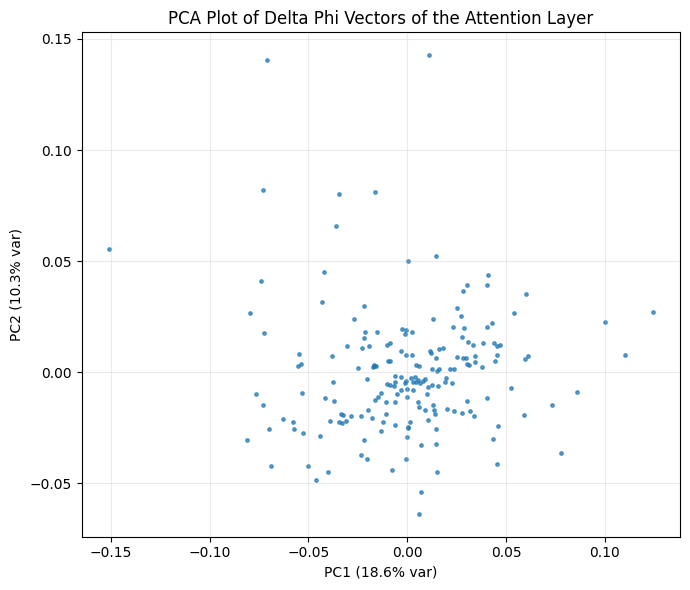

In [ ]:
attention_delta_phi_X_pca, attention_delta_phi_pca = efficient_pca(attention_delta_phis,
                                                                            'PCA Plot of Delta Phi Vectors of the Attention Layer',
                                                                            'attention_delta_phi_vecs_pca.png',
                                                                            proj_dir=proj_dir,
                                                                            method="randomized")

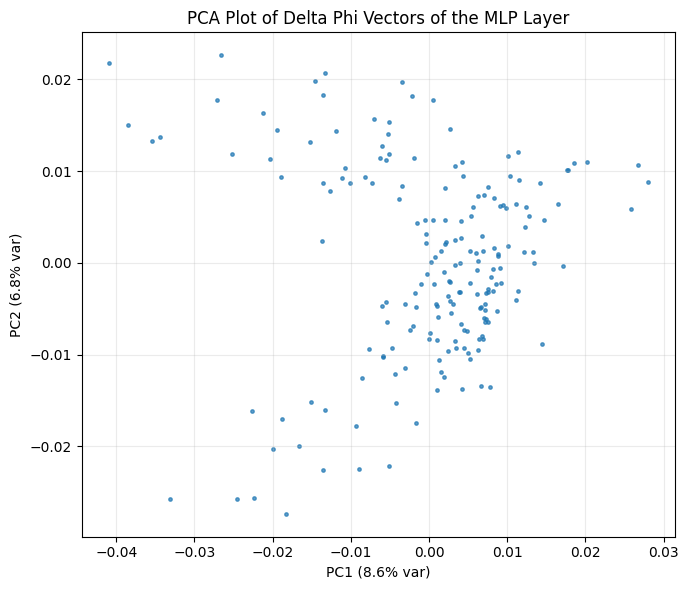

In [ ]:
mlp_delta_phi_X_pca, mlp_delta_phi_pca = efficient_pca(mlp_delta_phis,
                                                                'PCA Plot of Delta Phi Vectors of the MLP Layer',
                                                                'mlp_delta_phi_vecs_pca.png',
                                                                proj_dir=proj_dir,
                                                                method="randomized")

### UMAP-Based Delta Phi Vector Analysis

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


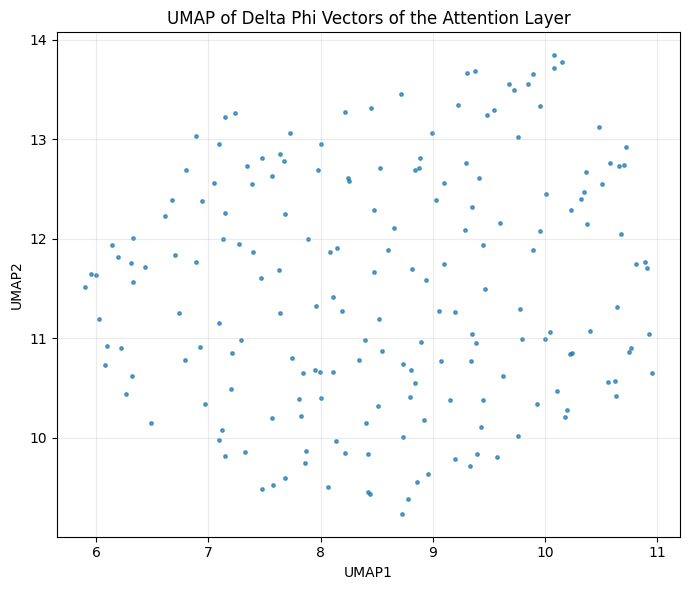

In [ ]:
attention_delta_phi_X_umap, attention_delta_phi_umap = create_vec_scatter_umap(attention_delta_phis,
                                                                              'UMAP of Delta Phi Vectors of the Attention Layer',
                                                                              'attention_delta_phi_vecs_umap.png',
                                                                               proj_dir = proj_dir)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


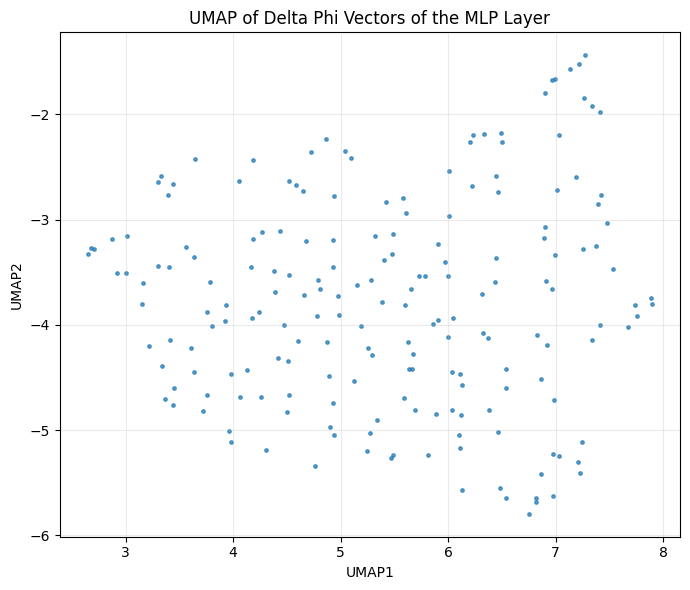

In [ ]:
mlp_delta_phi_X_umap, mlp_delta_phi_umap = create_vec_scatter_umap(mlp_delta_phis,
                                                                  'UMAP of Delta Phi Vectors of the MLP Layer',
                                                                  'mlp_delta_phi_vecs_umap.png',
                                                                  proj_dir = proj_dir)

### Clustering and Colored UMAP

#### Attention Layer

In [ ]:
pca_dims = 100
attention_delta_phi_X_cluster_pca, attention_delta_phi_cluster_pca = efficient_pca(attention_delta_phis,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = pca_dims)

# Explained variance check
attention_ex_var_ratio = attention_delta_phi_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {pca_dims} dimensions: {(attention_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 100 dimensions: 97.4616%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 100...


Fitting clusters: 100%|██████████| 96/96 [00:02<00:00, 40.23it/s]


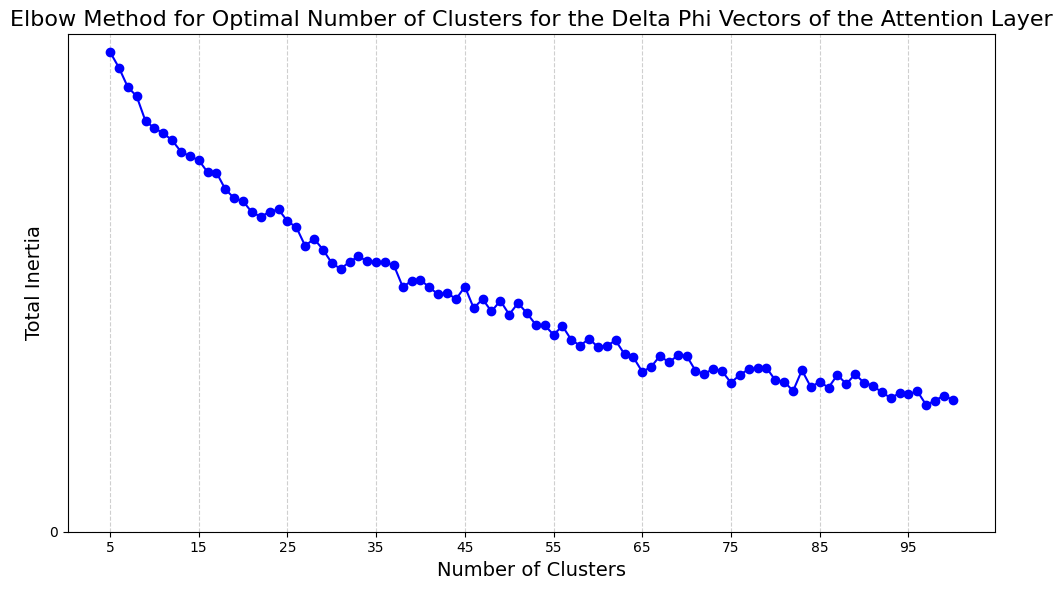

In [ ]:
# Creating elbow plot for the Delta Phi Vectors of the Attention Layer
elbow_plot_analysis(attention_delta_phi_X_cluster_pca,
                    'Elbow Method for Optimal Number of Clusters for the Delta Phi Vectors of the Attention Layer',
                    'elbow_attention_delta_phi_vecs.png')

In [ ]:
# Clustering the attention delta phi vectors

attention_delta_phi_X_cluster_pca = attention_delta_phi_X_cluster_pca.astype('float64')

n_clusters = 38
random_state_val = 42

# Initializing MiniBatchKMeans
attention_delta_phi_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
attention_delta_phi_kmeans.fit(attention_delta_phi_X_cluster_pca)

# Assigning each point to cluster
attention_delta_phi_color_labels = attention_delta_phi_kmeans.predict(attention_delta_phi_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 0.7898208475493719
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 1/30: mean batch inertia: 0.0036539215231318374
Minibatch step 2/30: mean batch inertia: 0.003476990333125485, ewa inertia: 0.003476990333125485
Minibatch step 3/30: mean batch inertia: 0.0034589617540414464, ewa inertia: 0.0034589617540414464
Minibatch step 4/30: mean batch inertia: 0.0032057830052578526, ewa inertia: 0.0032057830052578526
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 5/30: mean batch inertia: 0.0034202338843873493, ewa inertia: 0.0034202338843873493
Minibatch step 6/30: mean batch inertia: 0.0032919736200226536, ewa inertia: 0.0032919736200226536
Minibatch step 7/30: mean batch inertia: 0.003223264506155406, ewa inertia: 0.003223264506155406
Minibatch step 8/30: mean batch inertia: 0.00323459941863707, ewa inertia: 0.00323459941863707
Minibatch step 9/30: mean batch inertia: 0.0032263095939040194, ewa inertia: 0.003

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


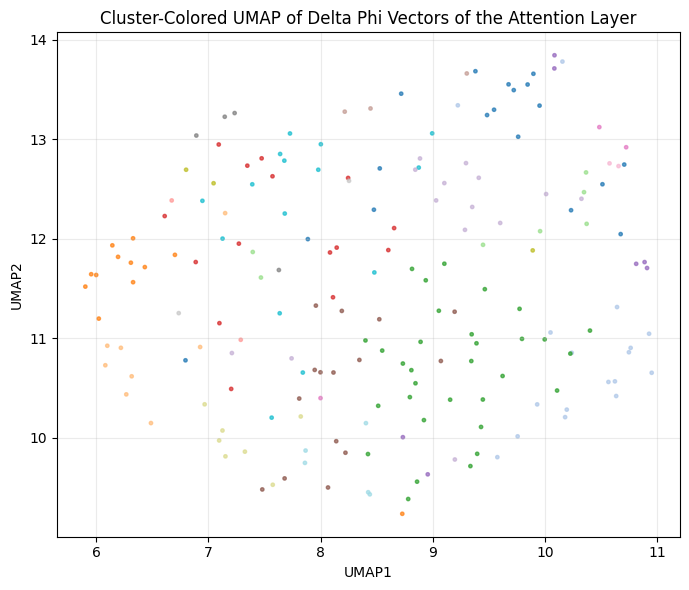

In [ ]:
attention_clustered_delta_phi_X_umap, attention_clustered_delta_phi_umap = create_vec_scatter_umap(attention_delta_phis,
                                                                              'Cluster-Colored UMAP of Delta Phi Vectors of the Attention Layer',
                                                                              'attention_delta_phi_vecs_clustered_umap.png',
                                                                              attention_delta_phi_color_labels,
                                                                              proj_dir = proj_dir)

#### MLP Layer

In [ ]:
mlp_delta_phi_X_cluster_pca, mlp_delta_phi_cluster_pca = efficient_pca(mlp_delta_phis,
                                                                    create_scatter = False,
                                                                    method="randomized",
                                                                    n_components = pca_dims)

# Explained variance check
mlp_ex_var_ratio = mlp_delta_phi_cluster_pca.explained_variance_ratio_.sum()
print(f'Explained Variance ratio for {pca_dims} dimensions: {(mlp_ex_var_ratio * 100):.4f}%')

Explained Variance ratio for 100 dimensions: 95.3088%


Starting MiniBatchKMeans fitting for number of clusters between 5 and 100...


Fitting clusters: 100%|██████████| 96/96 [00:02<00:00, 41.48it/s]


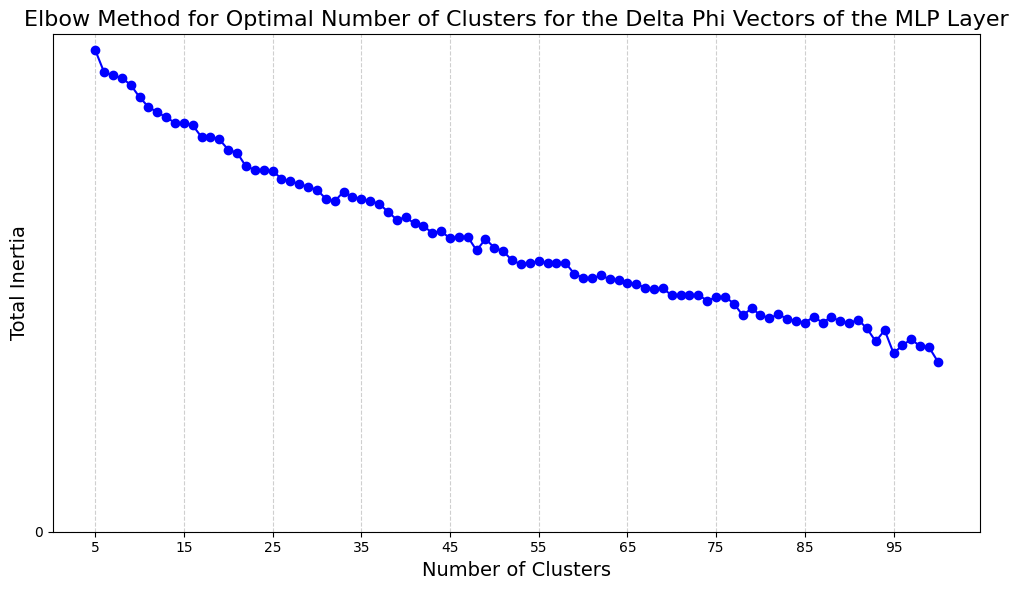

In [ ]:
# Creating elbow plot for the Delta Phi Vectors of the Attention Layer
elbow_plot_analysis(mlp_delta_phi_X_cluster_pca,
                    'Elbow Method for Optimal Number of Clusters for the Delta Phi Vectors of the MLP Layer',
                    'elbow_mlp_delta_phi_vecs.png')

In [ ]:
# Clustering the MLP delta phi vectors

mlp_delta_phi_X_cluster_pca = mlp_delta_phi_X_cluster_pca.astype('float64')

n_clusters = 40
random_state_val = 42

# Initializing MiniBatchKMeans
mlp_delta_phi_kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=random_state_val,
    n_init='auto',
    max_iter=30,
    verbose=1
)

# Training k-means model
mlp_delta_phi_kmeans.fit(mlp_delta_phi_X_cluster_pca)

# Assigning each point to cluster
mlp_delta_phi_color_labels = mlp_delta_phi_kmeans.predict(mlp_delta_phi_X_cluster_pca)

Init 1/1 with method k-means++
Inertia for init 1/1: 0.22802427910495282
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 1/30: mean batch inertia: 0.0011233419905622318
Minibatch step 2/30: mean batch inertia: 0.0009043525378230973, ewa inertia: 0.0009043525378230973
Minibatch step 3/30: mean batch inertia: 0.0009288522235314883, ewa inertia: 0.0009288522235314883
[MiniBatchKMeans] Reassigning 3 cluster centers.
Minibatch step 4/30: mean batch inertia: 0.0009359697786089937, ewa inertia: 0.0009359697786089937
Minibatch step 5/30: mean batch inertia: 0.0008707319751966199, ewa inertia: 0.0008707319751966199
Minibatch step 6/30: mean batch inertia: 0.0009651424267868974, ewa inertia: 0.0009651424267868974
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 7/30: mean batch inertia: 0.0009190367598991606, ewa inertia: 0.0009190367598991606
Minibatch step 8/30: mean batch inertia: 0.0009042879006230041, ewa inertia: 0.0009042879006230041
Minibatch step 9/30: mea

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


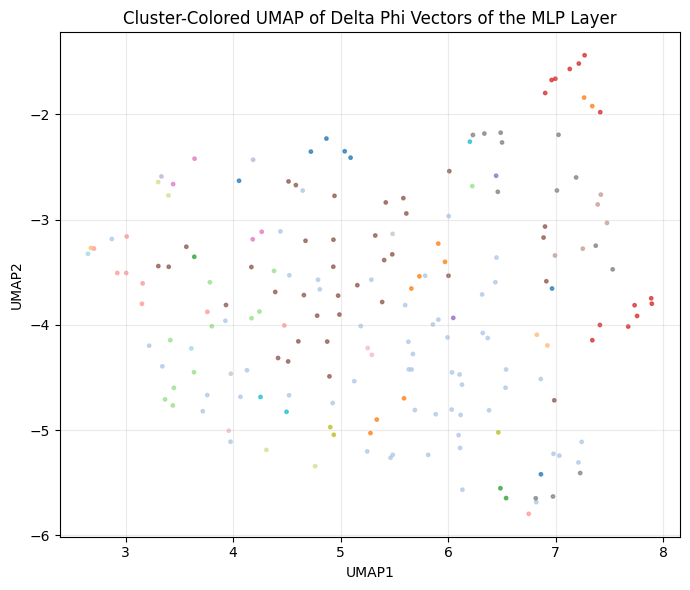

In [ ]:
mlp_clustered_delta_phi_X_umap, mlp_clustered_delta_phi_umap = create_vec_scatter_umap(mlp_delta_phis,
                                                                              'Cluster-Colored UMAP of Delta Phi Vectors of the MLP Layer',
                                                                              'mlp_delta_phi_vecs_clustered_umap.png',
                                                                              mlp_delta_phi_color_labels,
                                                                              proj_dir = proj_dir)

## Downloading the QLens Folder

In [ ]:
import zipfile

def zip_directory(source_dir, output_filename):
    """
    Zips the contents of the source_dir into the output_filename.
    """
    # Create the zip file object
    with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
        # Walk through all the files and folders in the source directory
        for foldername, subfolders, filenames in os.walk(source_dir):

            # 1. Add the current folder itself (optional, but good practice)
            # This ensures the root folder name is included in the archive structure
            relative_path = os.path.relpath(foldername, os.path.dirname(source_dir))
            if relative_path != ".": # Don't add current directory as empty entry
                zf.write(foldername, relative_path)

            # 2. Add all the files found in the current folder
            for filename in filenames:
                # Create the full path to the file
                full_path = os.path.join(foldername, filename)

                # Calculate the relative path within the zip archive
                # This removes the path *before* the source_dir
                archive_name = os.path.relpath(full_path, os.path.dirname(source_dir))

                # Write the file to the zip archive
                zf.write(full_path, archive_name)

    print(f"Successfully created zip file: {output_filename}")
    print(f"Contents of '{source_dir}' are now in the archive.")

# --- Configuration ---
folder_to_zip = r'/mmfs1/gscratch/stf/ipro13/Aditya' # Replace with the folder you want to zip
output_zip_file = r'QLens_20k.zip' # Replace with the desired output zip file name

# Call the function
zip_directory(folder_to_zip, output_zip_file)

Successfully created zip file: QLens_20k.zip
Contents of '/mmfs1/gscratch/stf/ipro13/Aditya' are now in the archive.
